# Machine learning flow surrogates

## Introduction
We propose a new and general workflow for a machine learning-based surrogate prototype to approximate the relationship between the reservoir parameters and the reservoir simulation response. We train and test a deep convolutional encoder-decoder network with a three-dimensional two-phase flow simulator
. Using simulation results, cumulative oil production and final recovery from each prototype the surrogate model captures the parameters that influence the most the responses on the producer wells and final recovery. The model allows the inclusion of time as a series of discrete time steps controlled 
by non-dimensional pore volumes.

## Convolutional neural networks

We opted to use the U-Net because it works with very few training images, the idea is to supplement a usual contracting network by successive layers. In order to localize high resolution features from the contracting path. A successive convolution layer learns to assemble a more precise output based on this information Ronneberger (2015).
Deep layers of linear convolutions with non linear activations to extract the multi-scale features or concepts from high dimensional input.

Therefore, we transform the surrogate modeling problem to an image-to-image regression problem.

## Problem statement

In this project we considered a 3-dimension fully implicit secondary recovery problem with water injection in different well injection schemes. The multiphase flow consists in oil and water as displacing fluid. However, our problem formulation allows the use of more than two phases and a wide range of volumetric fluid properties. We investigate two common allocation schemes:

 - Staggered line drive 
 - Direct line drive  

	 
Let $\textrm{S}$ be an image of the waterfront advancement from a dataset $\mathbf{S}$, which consists of different saturation samples from different injection well locations denoted by $y$ in various geological formations. The geological properties of interest include the permeability field $\textrm{K}$ and the porosity $\phi$. The diffusivity equation relates these geological properties in eq 1

\begin{equation} \label{eq:Diffusion}
\begin{split}
\overrightarrow{\nabla}\cdot\left(\rho_{\alpha}\overrightarrow{u}_{\alpha}\right)+\tilde{q}_{m,\alpha}=-\frac{\partial\left(\phi S_{\alpha}\rho_{\alpha}\right)}{\partial t},
\end{split}
\end{equation}

where

\begin{equation} \label{eq:Volumetric rate} \begin{split} 
\tilde{q}_{m,\alpha}=\frac{q_{m,\alpha}}{V_{b}}, 
\end{split} \end{equation}

    q(m,α)=  mass flow rate per volume of rock
    V_b= Bulk volume
    ρ= Density
    S= Saturation
    u= Fluid velocity
    q= Volumetric rate
    α= Phase. 
     
 Darcy's law defines velocity in equation 3

\begin{equation} \label{eq:Darcys}
\begin{split}
\overrightarrow{u}_{\alpha}\left(x\right)=-\frac{k_{r,\alpha}K\left(x,\text{n}\right)}{\eta_{\alpha}}\left(\overrightarrow{\nabla}p_{\alpha}-g\rho_{\alpha}\overrightarrow{\nabla}D\right),
\end{split}
\end{equation}

	K= Effective formation permeability
	k_r= Relative permeability
	p= Pressure
	η = viscosity
	D= Depth
	ρ= Density
	g = Acceleration due to gravity


Equation 4 describes the injection and production of fluid where $Q$ is positive for injection and negative for production.


\begin{equation} \label{eq:Rate}
\begin{split}
f\left(x\right)=\begin{cases}
Q, & \text{if}\:x=y,\\
0 & \text{otherwise},
\end{cases}
\end{split}
\end{equation}


Solution of the system of equations with finite differences or finite volume schemes on a discretized grid and differs from each other in used PDE's modifications and numerical integration schemes.

## Import

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use("ggplot")
%matplotlib inline

#from tqdm import tqdm_notebook, tnrange
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D, Cropping2D, Flatten, ZeroPadding2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
#from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage import data, io, filters
#from tensorflow.contrib.keras import models
#from tensorflow.contrib.keras import layers 

import units as u
from grid import limx,limy
from matplotlib.colors import LogNorm
#import math
#from tensorflow.keras import datasets, layers, models

from skimage.metrics import structural_similarity

from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from scipy import signal,stats

import cv2

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib as mpl
from matplotlib import rc
#rc('text', usetex=True)

#import seaborn as sns

#Remember to reload the images
import geostatspy.geostats as geostats
from Reservoir import Res
from grid import Imax,Jmax

#os.chdir("/Users/eduar/Dropbox/Python/Research/unet")
#os.chdir("/Users/em42363/Dropbox/Python/Research/unet")
#plt.style.use('styple.mplstyle')
# Make dataframe

#from plotly.offline import init_notebook_mode, iplot  # it help us plot the graphs on Jupyter Notebook
#import plotly.graph_objects as go

from scipy.interpolate import InterpolatedUnivariateSpline

#mpl.style.use(r'C:\Users\em42363\onedrive\Python\Research\unet\PaperFigures\styple.mplstyle')

import matplotlib.font_manager
matplotlib.font_manager._rebuild()

from scipy import integrate

In [2]:
import logging
logging.getLogger('tensorflow').disabled = True

In [3]:
tf.random.set_seed(1991)
np.random.RandomState(1991)
np.random.seed(1991)

## Custom Functions

In [4]:
def limits(array):
    Max=np.max(array)
    Min=np.min(array)
    return Max,Min
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]
def plot(array):
    return plt.imshow(array)
def Range(array):
    Max=np.max(array)
    Min=np.min(array)
    return Max-Min
def Scaler(X):
    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    #Min=X.min(axis=0)
    #Max=X.max(axis=0)
    return X_std
def invScaler(X,X_std):
    X_inv=X_std*(X.max() - X.min())+ X.min()
    return X_inv
def volumetrics(OOIP,TruthROV,PredROV):
     #Produced oil volume
    TruthRF=(np.sum(OOIP)-np.sum(TruthROV))/np.sum(OOIP)
    PredRF=(np.sum(OOIP)-np.sum(PredROV))/np.sum(OOIP)
    return TruthRF, PredRF
def similarity(truth,test):
    score = structural_similarity(truth,
                                          test,
                                          full=False, multichannel=False)
    return score
def MeanSE(train,test):
    err = np.sum((train.astype("float") - test.astype("float")) ** 2)
    err /= float(train.shape[0] * train.shape[1])
    return err

    #print("Image similarity", score)

    #plt.imshow(preds_val[ix,:,:,0])
    #plt.imshow(diff, cmap='gray')
def complete_sim(truth,test):
    (score, diff) = structural_similarity(truth,
                                          test,
                                          full=True, multichannel=False)
    return score,diff
def average(array):
    avg=np.average(array)
    return avg
def variance(array):
    var=np.var(array)
    return var
def mse_score_diff(train,test):
    (score, diff) = structural_similarity(train,
                                          test,
                                          full=True, multichannel=False)
    err = np.sum((train.astype("float") - test.astype("float")) ** 2)
    err /= float(train.shape[0] * train.shape[1])
    return score,diff,err

    #print("Image similarity", score)

    #plt.imshow(preds_val[ix,:,:,0])
    #plt.imshow(diff, cmap='gray')
    
EPSILON = 1e-15
def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted
def _percentage_error(actual: np.ndarray, predicted: np.ndarray):
    """
    Percentage error
    Note: result is NOT multiplied by 100
    """
    return _error(actual, predicted) / (actual + EPSILON)
def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-seasonality]
def _relative_error(actual: np.ndarray, predicted: np.ndarray, benchmark: np.ndarray = None):
    """ Relative Error """
    if benchmark is None or isinstance(benchmark, int):
        # If no benchmark prediction provided - use naive forecasting
        if not isinstance(benchmark, int):
            seasonality = 1
        else:
            seasonality = benchmark
        return _error(actual[seasonality:], predicted[seasonality:]) /\
               (_error(actual[seasonality:], _naive_forecasting(actual, seasonality)) + EPSILON)

    return _error(actual, predicted) / (_error(actual, benchmark) + EPSILON)
def mase(actual: np.ndarray, predicted: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    return mae(actual, predicted) / mae(actual[seasonality:], _naive_forecasting(actual, seasonality))
def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))

def statistics(elem):
    Mean=np.mean(elem)
    print('The mean is %2.3f' %Mean)
    StdDev=np.std(elem)
    print('The standard deviation is %2.3f' %StdDev)
    Min=np.min(elem)
    print('The minimum element is %2.3f' %Min)
    Max=np.max(elem)
    print('The maximum element is %2.3f' %Max)
    Range=np.ptp(elem)
    print('The range is %2.3f' %Range)
def return_statistics(elem):
    Mean=np.mean(elem)
    StdDev=np.std(elem)
    Min=np.min(elem)
    Max=np.max(elem)
    Range=np.ptp(elem)
    return Mean, StdDev, Min, Max, Range
def show2(a,b):
    fig, (ax1,ax2)=plt.subplots(1,2,figsize=(12,4))
    ax1.imshow(a)
    ax2.imshow(b)
def show3(a,b,c):
    fig, (ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,4))
    ax1.imshow(a)
    ax2.imshow(b)
    ax3.imshow(c)


In [5]:
import logging
logging.getLogger('tensorflow').disabled = True

## Define path 

In [6]:
path = ""
name = "model_k7_f9_Dropout"
weights_path = path + name + '.h5'

## Define GPU

In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [8]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [9]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Image details

In [10]:
# Set some parameters
im_width = 32#256#32#64#
im_height =32# 256#32#64#
n_channel=4
n_output=2
#n_channel=3
border = 0

## Truth image generation

In [11]:
TruthPerm = np.load('TruthPerm.npy')
TruthPor = np.load('TruthPor.npy')

In [12]:
limits(TruthPerm)

(12000.0, 0.04810802653677404)

### Truth image rescaling

In [13]:
Truth=np.zeros((im_width,im_height,2))

img=TruthPerm[:,:]
img2=TruthPor[:,:]
x_img1 = cv2.resize(img, dsize=(im_width, im_height), interpolation=cv2.INTER_NEAREST)
x_img2 = cv2.resize(img2, dsize=(im_width, im_height), interpolation=cv2.INTER_NEAREST)

Truth[:,:,0]=x_img1[:,:]
Truth[:,:,1]=x_img2[:,:]


## Training Images

### Training Image reshape

In [14]:
Porosity = np.load('Porosity.npy')
Permeability = np.load('Permeability.npy')
kfactor=Range(Permeability[:,:,0,:,:])
Permeability=Permeability/kfactor
Porevolinj= np.load('Porevolinj.npy')
Wells = np.load('Wells.npy')
Saturation=np.load('Saturation.npy')
pressure=np.load('Pressure.npy')

In [15]:
Pressure=Scaler(pressure)

In [16]:
n=Porosity.shape[3]*Porosity.shape[4]
X = np.zeros((n, im_height, im_width, n_channel), dtype=np.float32)
y = np.zeros((n, im_height, im_width, n_output), dtype=np.float32)

In [17]:
x_img=np.zeros((im_width,im_height,n_channel)) #Changed to pore volume injected
y_img=np.zeros((im_width,im_height,n_output))
#x_img=np.zeros((256,256)) #Changed to pore volume injected
n=0
for i in tqdm(range(Porosity.shape[3])):
    for j in range(Porosity.shape[4]):
        img=Porosity[:,:,0,i,j]
        img1 = cv2.resize(img, dsize=(im_width,im_height), interpolation=cv2.INTER_NEAREST)
        img=Permeability[:,:,0,i,j]
        img2 = cv2.resize(img, dsize=(im_width,im_height), interpolation=cv2.INTER_NEAREST)
        img=Porevolinj[:,:,0,i,j]
        img3 = cv2.resize(img, dsize=(im_width,im_height), interpolation=cv2.INTER_NEAREST)
        img=Wells[:,:,0,i,j]
        img4 = cv2.resize(img, dsize=(im_width,im_height), interpolation=cv2.INTER_NEAREST)
        img=Saturation[:,:,0,i,j]
        img5 = cv2.resize(img, dsize=(im_width,im_height), interpolation=cv2.INTER_NEAREST)
        img=Pressure[:,:,0,i,j]
        img6 = cv2.resize(img, dsize=(im_width,im_height), interpolation=cv2.INTER_NEAREST)
        x_img[:,:,0]=img1
        x_img[:,:,1]=img2
        x_img[:,:,2]=img3
        x_img[:,:,3]=img4
        y_img[:,:,0]=img5
        y_img[:,:,1]=img6
        #x_img = resize(x_img, (256, 256, n_channel), mode = 'constant', preserve_range = True)
        X[n] = x_img
        y[n] = y_img
        n=n+1
##print(limits(res))
#plt.imshow(res)
#plt.clim(Min,Max)
#plt.axis('off')

100%|██████████| 165/165 [00:00<00:00, 4020.89it/s]


## Split train test

In [20]:
X_train, X_test_ID, y_train, y_test_ID = train_test_split(X, y, test_size=0.3, random_state=50)

In [21]:
y_train.shape

(577, 32, 32, 2)

## Testing image generation

### Testing image reshape

In [22]:
Porosity = np.load('PorosityU.npy')
Permeability = np.load('PermeabilityU.npy')
kfactor=Range(Permeability[:,:,0,:,:])
Permeability=Permeability/kfactor
Porevolinj= np.load('PorevolinjU.npy')
Wells = np.load('WellsU.npy')
Saturation=np.load('SaturationU.npy')
pressure=np.load('PressureU.npy')

In [23]:
Pressure=Scaler(pressure)

In [25]:
n=Porosity.shape[3]*Porosity.shape[4]
X_test = np.zeros((n, im_height, im_width, n_channel), dtype=np.float32)
y_test = np.zeros((n, im_height, im_width, n_output), dtype=np.float32)

In [26]:
x_img=np.zeros((im_height,im_width,n_channel)) #Changed to pore volume injected
y_img=np.zeros((im_height,im_width,n_output))
#x_img=np.zeros((256,256)) #Changed to pore volume injected
n=0
for i in tqdm(range(Porosity.shape[3])):
    for j in range(Porosity.shape[4]):
        img=Porosity[:,:,0,i,j]
        img1 = cv2.resize(img, dsize=(im_width,im_height), interpolation=cv2.INTER_NEAREST)
        img=Permeability[:,:,0,i,j]
        img2 = cv2.resize(img, dsize=(im_width,im_height), interpolation=cv2.INTER_NEAREST)
        img=Porevolinj[:,:,0,i,j]
        img3 = cv2.resize(img, dsize=(im_width,im_height), interpolation=cv2.INTER_NEAREST)
        img=Wells[:,:,0,i,j]
        img4 = cv2.resize(img, dsize=(im_width,im_height), interpolation=cv2.INTER_NEAREST)
        img=Saturation[:,:,0,i,j]
        img5 = cv2.resize(img, dsize=(im_width,im_height), interpolation=cv2.INTER_NEAREST)
        img=Pressure[:,:,0,i,j]
        img6 = cv2.resize(img, dsize=(im_width,im_height), interpolation=cv2.INTER_NEAREST)
        x_img[:,:,0]=img1
        x_img[:,:,1]=img2
        x_img[:,:,2]=img3
        x_img[:,:,3]=img4
        y_img[:,:,0]=img5
        y_img[:,:,1]=img6
        #x_img = resize(x_img, (256, 256, n_channel), mode = 'constant', preserve_range = True)
        X_test[n] = x_img
        y_test[n] = y_img
        n=n+1
##print(limits(res))
#plt.imshow(res)
#plt.clim(Min,Max)
#plt.axis('off')

100%|██████████| 80/80 [00:00<00:00, 2558.01it/s]


## Convolutional U-Net definition

In [29]:
def make_gaussian_2d_kernel(sigma, truncate=4.0, dtype=tf.float32):
    radius = tf.cast(sigma * truncate,tf.int32)
    x = tf.cast(tf.range(-radius, radius + 1), dtype=dtype)
    k = tf.exp(-0.5 * tf.square(x / sigma))
    k = k / tf.reduce_sum(k)
    return tf.expand_dims(k, 1) * k

def gaussian_filter(image,sigma):
# Input data
#image = tf.placeholder(tf.float32, [16, 96, 96, 3])
# Convolution kernel
    kernel = make_gaussian_2d_kernel(sigma)

    kernel = tf.tile(kernel[:, :, tf.newaxis, tf.newaxis], [1, 1, 2, 1])
    image_filtered = tf.nn.separable_conv2d(image, kernel, 
                                            tf.eye(2, batch_shape=[1, 1]),
                                            strides=[1, 1, 1, 1], padding='SAME')
    return image_filtered

def custom_loss(y_actual,y_pred):
    K1 = 0.01
    K2 = 0.03
    sigma = 1.5 #Defined as 1.5
    dmax=1
    dmin=-1
    data_range = dmax - dmin
    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2
    cov_norm = 1.0
    #win_size = 7
    ux = gaussian_filter(y_actual,sigma)
    uy = gaussian_filter(y_pred,sigma)
    uxx = gaussian_filter(y_actual * y_actual,sigma)
    uyy = gaussian_filter(y_pred * y_pred,sigma)
    uxy = gaussian_filter(y_actual * y_pred,sigma)
    
    vx = cov_norm * (uxx - ux * ux)
    vy = cov_norm * (uyy - uy * uy)
    vxy = cov_norm * (uxy - ux * uy)

    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    
    D = B1 * B2
    S = (A1 * A2) / D

    # to avoid edge effects will ignore filter radius strip around edges
    #pad = (win_size - 1) // 2

    # compute (weighted) mean of ssim
    #mssim = crop(S, pad).mean()
    #mssim = tf.math.reduce_mean(S)
    mssim = tf.math.reduce_mean(S)
    loss2=tf.keras.losses.MSE(y_actual,y_pred)
    #total=0.5*(1-mssim)+0.5*(loss2)
    total=(1-mssim)+(loss2)
#    total=(1-mssim)
    return total

def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = (target.get_shape()[2] - refer.get_shape()[2])  #.value
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw / 2), int(cw / 2) + 1
    else:
        cw1, cw2 = int(cw / 2), int(cw / 2)
    # height, the 2nd dimension
    ch = (target.get_shape()[1] - refer.get_shape()[1])  #.value
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch / 2), int(ch / 2) + 1
    else:
        ch1, ch2 = int(ch / 2), int(ch / 2)

    return (ch1, ch2), (cw1, cw2)

def conv2d_block(input_tensor, n_filters, kernel_size, batchnorm):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x1 = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    # second layer
    x2 = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x1)
    if batchnorm:
        x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    return x2

def create_model(img_shape, num_class, dropout, kernel_size, n_filters, batchnorm):

    concat_axis = 3
    inputs =  Input(shape = img_shape)

    conv1 = conv2d_block(inputs, n_filters * 1, kernel_size, batchnorm = batchnorm)
    #conv1 =  Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same')(inputs)
    #conv1 =  Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same')(conv1)
    pool1 =  MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 =  Dropout(dropout)(pool1)
    
    #conv2 =  Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same')(pool1)
    #conv2 =  Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same')(conv2)
    conv2 = conv2d_block(pool1, n_filters * 2, kernel_size, batchnorm = batchnorm)
    pool2 =  MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 =  Dropout(dropout)(pool2)
    
    #conv3 =  Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same')(pool2)
    #conv3 =  Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same')(conv3)
    conv3 = conv2d_block(pool2, n_filters * 4, kernel_size, batchnorm = batchnorm)
    pool3 =  MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 =  Dropout(dropout)(pool3)

    #conv4 =  Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same')(pool3)
    #conv4 =  Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same')(conv4)
    conv4 = conv2d_block(pool3, n_filters * 8, kernel_size, batchnorm = batchnorm)
    pool4 =  MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 =  Dropout(dropout)(pool4)

    #conv5 =  Conv2D(512, (kernel_size, kernel_size), activation='relu', padding='same')(pool4)
    #conv5 =  Conv2D(512, (kernel_size, kernel_size), activation='relu', padding='same')(conv5)
    conv5 = conv2d_block(pool4, n_filters * 16, kernel_size, batchnorm = batchnorm)
    
    up_conv5 =  UpSampling2D(size=(2, 2))(conv5)
    ch, cw = get_crop_shape(conv4, up_conv5)
    crop_conv4 =  Cropping2D(cropping=(ch,cw))(conv4)
    
    up6 =  concatenate([up_conv5, crop_conv4], axis=concat_axis)
    up6=Dropout(dropout)(up6)
    #conv6 =  Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same')(up6)
    #conv6 =  Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same')(conv6)
    conv6 = conv2d_block(up6, n_filters * 8, kernel_size, batchnorm = batchnorm)
    
    up_conv6 =  UpSampling2D(size=(2, 2))(conv6)
    ch, cw = get_crop_shape(conv3, up_conv6)
    crop_conv3 =  Cropping2D(cropping=(ch,cw))(conv3)
    up7 =  concatenate([up_conv6, crop_conv3], axis=concat_axis) 
    up7=Dropout(dropout)(up7)
    #conv7 =  Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same')(up7)
    #conv7 =  Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same')(conv7)
    conv7 = conv2d_block(up7, n_filters * 4, kernel_size, batchnorm = batchnorm)

    up_conv7 =  UpSampling2D(size=(2, 2))(conv7)
    ch, cw = get_crop_shape(conv2, up_conv7)
    crop_conv2 =  Cropping2D(cropping=(ch,cw))(conv2)
    up8 =  concatenate([up_conv7, crop_conv2], axis=concat_axis)
    up8=Dropout(dropout)(up8)
    #conv8 =  Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same')(up8)
    #conv8 =  Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same')(conv8)
    conv8 = conv2d_block(up8, n_filters * 2, kernel_size, batchnorm = batchnorm)

    up_conv8 =  UpSampling2D(size=(2, 2))(conv8)
    ch, cw = get_crop_shape(conv1, up_conv8)
    crop_conv1 =  Cropping2D(cropping=(ch,cw))(conv1)
    up9 =  concatenate([up_conv8, crop_conv1], axis=concat_axis)
    up9=Dropout(dropout)(up9)
    #conv9 =  Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same')(up9)
    #conv9 =  Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same')(conv9)
    conv9 = conv2d_block(up9, n_filters * 1, kernel_size, batchnorm = batchnorm)

    ch, cw = get_crop_shape(inputs, conv9)
    conv9 =  ZeroPadding2D(padding=((ch[0], ch[1]), (cw[0], cw[1])))(conv9)
    conv10 =  Conv2D(num_class, (1, 1), activation='sigmoid')(conv9)
    #conv10 =  Conv2D(num_class, (1, 1), activation='relu')(conv9)
    model = Model(inputs=inputs, outputs=conv10)

    return model
#Latest working

## Model definition

In [31]:
img_shape = [im_height, im_width, n_channel]
num_class = 2

In [32]:
learn_rate = 0.0001
opt  = Adam(lr=learn_rate)
model=create_model(img_shape, num_class, dropout=0.1, kernel_size=7, n_filters=9, batchnorm=False)
model.compile(loss=custom_loss, #
                 optimizer=opt,
                 metrics=['mse','acc',custom_loss])

In [33]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 9)    1773        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 9)    0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 9)    3978        activation[0][0]                 
_______________________________________________________________________________________

## Model optimization using OPTUNA

### Without dropout in the input layer

In [ ]:
import optuna
from optkeras.optkeras import OptKeras
import optkeras
from keras.backend import clear_session
from optuna.integration import TFKerasPruningCallback
import joblib

In [ ]:
def make_gaussian_2d_kernel(sigma, truncate=4.0, dtype=tf.float32):
    radius = tf.cast(sigma * truncate,tf.int32)
    x = tf.cast(tf.range(-radius, radius + 1), dtype=dtype)
    k = tf.exp(-0.5 * tf.square(x / sigma))
    k = k / tf.reduce_sum(k)
    return tf.expand_dims(k, 1) * k

def gaussian_filter(image,sigma):
# Input data
#image = tf.placeholder(tf.float32, [16, 96, 96, 3])
# Convolution kernel
    kernel = make_gaussian_2d_kernel(sigma)

    kernel = tf.tile(kernel[:, :, tf.newaxis, tf.newaxis], [1, 1, 2, 1])
    image_filtered = tf.nn.separable_conv2d(image, kernel, 
                                            tf.eye(2, batch_shape=[1, 1]),
                                            strides=[1, 1, 1, 1], padding='SAME')
    return image_filtered

def custom_loss(y_actual,y_pred):
    K1 = 0.01
    K2 = 0.03
    sigma = 1.5 #Defined as 1.5
    dmax=1
    dmin=-1
    data_range = dmax - dmin
    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2
    cov_norm = 1.0
    #win_size = 7
    ux = gaussian_filter(y_actual,sigma)
    uy = gaussian_filter(y_pred,sigma)
    uxx = gaussian_filter(y_actual * y_actual,sigma)
    uyy = gaussian_filter(y_pred * y_pred,sigma)
    uxy = gaussian_filter(y_actual * y_pred,sigma)
    
    vx = cov_norm * (uxx - ux * ux)
    vy = cov_norm * (uyy - uy * uy)
    vxy = cov_norm * (uxy - ux * uy)

    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    
    D = B1 * B2
    S = (A1 * A2) / D

    # to avoid edge effects will ignore filter radius strip around edges
    #pad = (win_size - 1) // 2

    # compute (weighted) mean of ssim
    #mssim = crop(S, pad).mean()
    #mssim = tf.math.reduce_mean(S)
    mssim = tf.math.reduce_mean(S)
    loss2=tf.keras.losses.MAE(y_actual,y_pred)
    #total=0.5*(1-mssim)+0.5*(loss2)
    total=(1-mssim)+(loss2)
#    total=(1-mssim)
    return total

def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = (target.get_shape()[2] - refer.get_shape()[2])  #.value
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw / 2), int(cw / 2) + 1
    else:
        cw1, cw2 = int(cw / 2), int(cw / 2)
    # height, the 2nd dimension
    ch = (target.get_shape()[1] - refer.get_shape()[1])  #.value
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch / 2), int(ch / 2) + 1
    else:
        ch1, ch2 = int(ch / 2), int(ch / 2)

    return (ch1, ch2), (cw1, cw2)

def conv2d_block(input_tensor, n_filters, kernel_size, batchnorm):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x1 = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    # second layer
    x2 = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x1)
    if batchnorm:
        x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    return x2

def create_model(img_shape, num_class, dropout, kernel_size, n_filters, batchnorm):

    concat_axis = 3
    inputs =  Input(shape = img_shape)

    conv1 = conv2d_block(inputs, n_filters * 1, kernel_size, batchnorm = batchnorm)
    #conv1 =  Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same')(inputs)
    #conv1 =  Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same')(conv1)
    pool1 =  MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 =  Dropout(dropout,seed=1991)(pool1,training=True)
    
    #conv2 =  Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same')(pool1)
    #conv2 =  Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same')(conv2)
    conv2 = conv2d_block(pool1, n_filters * 2, kernel_size, batchnorm = batchnorm)
    pool2 =  MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 =  Dropout(dropout,seed=4)(pool2,training=True)
    
    #conv3 =  Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same')(pool2)
    #conv3 =  Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same')(conv3)
    conv3 = conv2d_block(pool2, n_filters * 4, kernel_size, batchnorm = batchnorm)
    pool3 =  MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 =  Dropout(dropout,seed=1991)(pool3,training=True)

    #conv4 =  Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same')(pool3)
    #conv4 =  Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same')(conv4)
    conv4 = conv2d_block(pool3, n_filters * 8, kernel_size, batchnorm = batchnorm)
    pool4 =  MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 =  Dropout(dropout,seed=1991)(pool4,training=True)

    #conv5 =  Conv2D(512, (kernel_size, kernel_size), activation='relu', padding='same')(pool4)
    #conv5 =  Conv2D(512, (kernel_size, kernel_size), activation='relu', padding='same')(conv5)
    conv5 = conv2d_block(pool4, n_filters * 16, kernel_size, batchnorm = batchnorm)
    
    up_conv5 =  UpSampling2D(size=(2, 2))(conv5)
    ch, cw = get_crop_shape(conv4, up_conv5)
    crop_conv4 =  Cropping2D(cropping=(ch,cw))(conv4)
    up6 =  concatenate([up_conv5, crop_conv4], axis=concat_axis)
    up6=Dropout(dropout,seed=1991)(up6,training=True)
    #conv6 =  Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same')(up6)
    #conv6 =  Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same')(conv6)
    conv6 = conv2d_block(up6, n_filters * 8, kernel_size, batchnorm = batchnorm)
    
    up_conv6 =  UpSampling2D(size=(2, 2))(conv6)
    ch, cw = get_crop_shape(conv3, up_conv6)
    crop_conv3 =  Cropping2D(cropping=(ch,cw))(conv3)
    up7 =  concatenate([up_conv6, crop_conv3], axis=concat_axis) 
    up7=Dropout(dropout,seed=1991)(up7,training=True)
    #conv7 =  Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same')(up7)
    #conv7 =  Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same')(conv7)
    conv7 = conv2d_block(up7, n_filters * 4, kernel_size, batchnorm = batchnorm)

    up_conv7 =  UpSampling2D(size=(2, 2))(conv7)
    ch, cw = get_crop_shape(conv2, up_conv7)
    crop_conv2 =  Cropping2D(cropping=(ch,cw))(conv2)
    up8 =  concatenate([up_conv7, crop_conv2], axis=concat_axis)
    up8=Dropout(dropout,seed=1991)(up8,training=True)
    #conv8 =  Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same')(up8)
    #conv8 =  Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same')(conv8)
    conv8 = conv2d_block(up8, n_filters * 2, kernel_size, batchnorm = batchnorm)

    up_conv8 =  UpSampling2D(size=(2, 2))(conv8)
    ch, cw = get_crop_shape(conv1, up_conv8)
    crop_conv1 =  Cropping2D(cropping=(ch,cw))(conv1)
    up9 =  concatenate([up_conv8, crop_conv1], axis=concat_axis)
    up9=Dropout(dropout,seed=1991)(up9,training=True)
    #conv9 =  Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same')(up9)
    #conv9 =  Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same')(conv9)
    conv9 = conv2d_block(up9, n_filters * 1, kernel_size, batchnorm = batchnorm)

    ch, cw = get_crop_shape(inputs, conv9)
    conv9 =  ZeroPadding2D(padding=((ch[0], ch[1]), (cw[0], cw[1])))(conv9)
    conv10 =  Conv2D(num_class, (1, 1), activation='sigmoid')(conv9)
    #conv10 =  Conv2D(num_class, (1, 1), activation='relu')(conv9)
    model = Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
img_shape = [im_height, im_width, n_channel]
num_class = 2


In [ ]:
#Randomly sample from the 400 cases
def get_cases(y_test, X_test, n_cases):
    np.random.seed(1)
    idx = np.random.choice(y_test.shape[0], n_cases, replace=False)
    y_s = y_test[idx, :, :, :]
    X_s = X_test[idx, :, :, :]
    return y_s, X_s


def evaluate_cases(model, X_s, batch_size):
    #Take n_samples to draw a distribution
    n_samples = 200
    mc_predictions = np.zeros((n_samples, X_s.shape[0], im_width, im_height))
    for i in range(n_samples):
        #y_p = mc_model.predict(X_test, batch_size=4)
        y_p = model.predict(X_s, verbose=1, batch_size=batch_size)
        mc_predictions[i] = (y_p[:, :, :, 0])
    tf.keras.backend.clear_session()
    return mc_predictions


def get_dataframe(mc_predictions, y_s, X_s):
    # Perform volumetric calculations
    Lx = 3280 / 2  #ft
    Dx = Lx / im_width
    Ly = 3280 / 2  #ft
    Dy = Lx / im_height
    Lz = 32.8  #ft
    Swi = 0.2
    Soi = 1 - Swi
    ft_bl = (28.3168 / 159)  #cubic ft to barrels
    Vp = Dx * Dy * Lz * (X_s[:, :, :, 0]) * ft_bl  # in bl
    OOIP = Vp * (1 - Swi)
    OWIP = Vp * (Swi)

    TruthSo = 1 - y_s[:, :, :, 0]
    PredSo = 1 - mc_predictions[:, :, :, :]

    #TruthWV=Vp*y_s[:,:,:,0]
    #PredWV=Vp*mc_predictions[:,:,:,:]

    TruthROV = Vp * TruthSo  #Residual oil volume in the reservoir truth
    PredROV = Vp * PredSo  #Residual oil volume in the reservoir estimated

    #Np_t=(OOIP-TruthROV)
    #Np_p=(OOIP-PredROV)

    #RF_t=(OOIP-TruthROV)/OOIP
    #RF_p=(OOIP-PredROV)/OOIP

    #Wi_t=(TruthWV-OWIP)
    #Wi_p=(PredWV-OWIP)

    Np = np.zeros(OOIP.shape[0])
    Np_pred = np.zeros((PredROV.shape[0], OOIP.shape[0]))
    Diff = np.zeros((PredROV.shape[0], OOIP.shape[0]))
    STD_u = np.zeros(OOIP.shape[0])
    Var_RF = np.zeros(OOIP.shape[0])
    TruthRF = np.zeros(OOIP.shape[0])
    PredRF = np.zeros((PredROV.shape[0], OOIP.shape[0]))
    avg_dif = np.zeros(OOIP.shape[0])
    Min_u = np.zeros(OOIP.shape[0])
    Max_u = np.zeros(OOIP.shape[0])
    Range = np.zeros(OOIP.shape[0])
    Var_Np = np.zeros(OOIP.shape[0])
    MeanNp = np.zeros(OOIP.shape[0])
    MeanRec = np.zeros(OOIP.shape[0])
    MeanPred = np.zeros(OOIP.shape[0])

    for i in range(OOIP.shape[0]):
        for j in range(PredROV.shape[0]):
            Np_pred[j,
                    i] = (np.sum(OOIP[i, :, :]) - np.sum(PredROV[j, i, :, :]))
            #Diff[j, i] = (Np_pred[j, i] - Np[i])
            PredRF[j,
                   i] = (np.sum(OOIP[i, :, :]) -
                         np.sum(PredROV[j, i, :, :])) / np.sum(OOIP[i, :, :])

        #Min_u[i] = np.min(Np_pred[:, i])
        #Max_u[i] = np.max(Np_pred[:, i])
        #MeanNp[i]=np.average(Np_pred[:,i])
        MeanRec[i] = np.average(PredRF[:, i])
        MeanPred[i] = np.average(Np_pred[:, i])
        #Range[i] = np.ptp(Diff[:, i])
        Np[i] = (np.sum(OOIP[i, :, :]) - np.sum(TruthROV[i, :, :]))
        TruthRF[i] = (np.sum(OOIP[i, :, :]) -
                      np.sum(TruthROV[i, :, :])) / np.sum(OOIP[i, :, :])
        STD_u[i] = np.std(Np_pred[:, i])
        Var_RF[i] = np.var(PredRF[:, i])
        Var_Np[i] = np.var(Np_pred[:, i])
        #avg_dif[i] = np.average(Diff[:, i])

    ## For Np
    xline = [0, 1000000]
    yline = [0, 1000000]
    plt.figure(figsize=(8, 5))
    #plt.plot(Np_pred[0,:],Np,'ko',label='Correlation coefficient = ');
    plt.errorbar(MeanPred, Np, xerr=STD_u * 2, fmt='k.', ecolor='k')
    plt.plot(xline, yline, '-k')
    #plt.title(
#        'Cumulative oil production and error bars from Monte Carlo dropout')
    plt.xlabel('Predicted value, $\hat{y}$ [bl]')
    plt.ylabel('True value, $y$ [bl]')
    #plt.legend(loc='best');
    plt.show()

    Sw_avg = []
    for i in range(mc_predictions.shape[0]):
        Sw_avg.append(np.average(mc_predictions[i, 9, :, :]))

    std_Sw = np.std(Sw_avg)

    # Histograms
    n_bins = 20
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    N, bins, patches = axs.hist(Sw_avg,
                                bins=n_bins,
                                label='$\sigma$ = %2.5f' % std_Sw)
    #axs.set_title('Root Mean squared error in barrels for each cell');
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        #color = plt.cm.YlGnBu(norm(thisfrac))
        color = plt.cm.binary(norm(thisfrac))
        thispatch.set_facecolor(color)
    plt.legend()
    plt.ylabel('Number of cases')
    plt.xlabel('MSE in water saturation')

    stdNp = np.std(Np_pred[:, 9])
    n_bins = 20
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    N, bins, patches = axs.hist(Np_pred[:, 9],
                                bins=n_bins,
                                label='$\sigma$ = %2.2f barrels' % stdNp)
    #axs.set_title('Root Mean squared error in barrels for each cell');
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        #color = plt.cm.YlGnBu(norm(thisfrac))
        color = plt.cm.binary(norm(thisfrac))
        thispatch.set_facecolor(color)
    #plt.xlim(2000,8000)
    plt.legend()
    plt.ylabel('Number of cases')
    plt.xlabel('Predicted cumulative volume')

    df = pd.DataFrame()
    #df['PredRF']=PredRF[25,:]MeanRec
    df['PredRF'] = MeanRec[:]
    df['TruthRF'] = TruthRF
    df['Var_RF'] = Var_RF
    df['Var_Np'] = Var_Np
    df['Np_pred'] = Np_pred[0, :]
    df['Np'] = Np

    df.head()
    return df


def get_GAP(df, sk_estimate, sk_var, true_value, n_quantiles):
    F = np.zeros(
        (len(df),
         ))  # it will store the probabilities associated to the true values z
    # it will store the indicator function results
    indicator_func = np.zeros((len(df), n_quantiles))
    #     perc = np.arange(0.01, 1.00, 0.01)
    perc = np.linspace(0.01, 1.00, n_quantiles)
    # range of symmetric p-probability intervals
    plow = (1 - perc) / 2
    pupp = (1 + perc) / 2

    # column vector with all the sk standard deviation
    std = np.sqrt(df[sk_var])

    # F(u;z(u)|n(u))
    for index in range(len(df)):
        F[index] = stats.norm.cdf(df.loc[index, true_value],
                                  loc=df.loc[index, sk_estimate],
                                  scale=std[index])

    # for each value of F, compute the indicator function
    for index, f in enumerate(F):
        indicator_func[index] = np.array([
            1 if proba_low < f <= proba_upp else 0
            for proba_low, proba_upp in zip(plow, pupp)
        ])

    print(f'Overall uncertainty = {df[sk_var].mean():.6f}')
    U = df[sk_var].mean()
    IF = indicator_func
    ##% Goodness, Precision and Accuracy
    #a(p) is the indicator function IF
    #     perc=np.arange(0.0,1.00,0.01)
    #     G=(3*IF-2)*(np.mean(IF,axis=0)-perc)
    #     G=G[1,:]
    #     g=InterpolatedUnivariateSpline(perc,G,k=1.00)
    #     P=IF*((np.mean(IF,axis=0)-perc))
    #     P=P[1,:]
    #     p=InterpolatedUnivariateSpline(perc,G,k=1.00)
    #     A=IF[1,:]
    #     a=InterpolatedUnivariateSpline(perc,A,k=1.00)
    #     Accuracy=a.integral(0,1)
    #     Goodness=1-g.integral(0,1)
    #     Precision= 1-2*p.integral(0,1)
    AvgG = 0
    AvgP = 0
    AvgA = 0
    for i in range(IF.shape[0]):
        G = (3 * IF - 2) * (np.mean(IF, axis=0) - perc)
        G = G[i, :]
        g = InterpolatedUnivariateSpline(perc, G, k=1.00)
        P = IF * ((np.mean(IF, axis=0) - perc))
        P = P[i, :]
        p = InterpolatedUnivariateSpline(perc, G, k=1.00)
        A = IF[i, :]
        a = InterpolatedUnivariateSpline(perc, A, k=1.00)
        Accuracy = a.integral(0, 1)
        Precision = 1 - 2 * p.integral(0, 1)
        Goodness = 1 - g.integral(0, 1)

        if Goodness > 1:
            Goodness = 1
        if Goodness < 0:
            Goodness = 0
        if Accuracy > 1:
            Accuracy = 1
        if Accuracy < 0:
            Accuracy = 0
        if Precision > 1:
            Precision = 1
        if Precision < 0:
            Precision = 0

        AvgG = AvgG + Goodness
        AvgP = AvgP + Precision
        AvgA = AvgA + Accuracy

    AvgG = AvgG / int(IF.shape[0])
    AvgP = AvgP / int(IF.shape[0])
    AvgA = AvgA / int(IF.shape[0])
    #AvgG=AvgG/int(IF.shape[0]+IF.shape[1])
    #AvgP=AvgP/int(IF.shape[0]+IF.shape[1])
    #AvgA=AvgA/int(IF.shape[0]+IF.shape[1])

    ###################################
    #     Bootstrap for uncertainty
    ###################################
    L = 100  # number of realizations changed from 2000
    mean = np.empty((L, len(perc)))
    std = np.empty_like(mean)
    for p_interv in range(len(perc)):
        for l in np.arange(0, L):
            samples = random.choices(indicator_func[:, p_interv],
                                     k=indicator_func.shape[0])
            mean[l, p_interv] = np.mean(samples)

    plt.figure(figsize=(10, 6))
    plt.plot(perc,
                np.round(np.std(mean, axis=0)+np.mean(indicator_func, axis=0), 3),
            '--k')
    plt.plot(perc,
             np.round(np.mean(indicator_func, axis=0), 3),
             '-ok',
            markersize=2)
    plt.plot(perc,
             np.round(np.mean(indicator_func, axis=0)-np.std(mean, axis=0), 3),
             '--k')
    plt.plot([0, 1],
             [0, 1],'-k')
    plt.ylabel(r'$\xi (p)$')
    plt.xlabel('Probability interval $p$')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.show()

    return AvgG, AvgP, AvgA, U  #Goodness,Precision,Accuracy

In [ ]:
ID_G_list=[]
ID_MSE_list=[]
ID_MAE_list=[]
ID_G_div_MSE_list=[]
ID_G_sum_MSE_list=[]
ID_G_div_MAE_list=[]
ID_G_sum_MAE_list=[]
ID_G_sum_MSE_sq_list=[]

OD_G_list=[]
OD_MSE_list=[]
OD_MAE_list=[]
OD_G_div_MSE_list=[]
OD_G_sum_MSE_list=[]
OD_G_div_MAE_list=[]
OD_G_sum_MAE_list=[]
OD_G_sum_MSE_sq_list=[]

In [ ]:
def objective(trial):
    # Clear clutter from previous Keras session graphs.
    clear_session()
    
    batch_size=8
    dropout=0.85#trial.suggest_discrete_uniform('Dropout', 0.05, 0.95, 0.01)
    kernel_size=trial.suggest_int('Kernel', 4, 14, step=1)
    epochs=22
    learning_rate=0.00013#float(trial.suggest_discrete_uniform('learn_rate',0.0001, .0002 , 0.00001))
    n_filters=trial.suggest_int('Filter', 8, 16, step=1)
    
    
    

    model = create_model(
        img_shape,
        num_class,
        dropout=dropout,
        #kernel_size=7,
        kernel_size=kernel_size,
        #n_filters=9,
        n_filters=n_filters,
        batchnorm=False)

    
    opt = Adam(lr=learning_rate)
    #     model.compile(loss='binary_crossentropy', #
    #                   optimizer=opt,
    #                   metrics=['accuracy'])
    model.compile(
        loss=custom_loss,  #
        optimizer=opt,
        metrics=['mse','mae'])

    #callbacks = [EarlyStopping(monitor='mse', patience=3, verbose=1)]  #,#EarlyStopping(monitor='val_mse', patience=3, verbose=1),

    model.fit(
        x=X_train,
        y=y_train,
        #validation_data=(X_valid, y_valid),
        #batch_size=6,
        batch_size=batch_size,
        verbose=1,
        epochs=epochs,
        #callbacks=callbacks,
        shuffle=False)
    
    model.save_weights('{0}-{1}.h5'.format(kernel_size,n_filters))

    # Evaluate the model accuracy on the validation set.
    # ===========Inside distribution===================
    score_ID = model.evaluate(X_test_ID, y_test_ID, verbose=0)
    #score1 = model.evaluate(X_test, y_test, verbose=0)
    
    mc_predictions = evaluate_cases(model, X_test_ID,batch_size)
    print('==========================ID=============================')
    df_ID = get_dataframe(mc_predictions, y_test_ID, X_test_ID)
    AvgG, AvgP, AvgA, U = get_GAP(df_ID,
                               'PredRF',
                               'Var_RF',
                               'TruthRF',
                               n_quantiles=100)
    
#    if AvgG>0.7:
#        Score = (score[1]/AvgG)*U  #+AvgP+AvgA
    #else:
        #Score=0.001
    #Score = (score[1]/AvgG)  #+AvgP+AvgA
    Score=AvgG
    
    ID_MSE_list.append(score_ID[1])
    ID_G_div_MSE_list.append(score_ID[1]/AvgG)
    ID_G_sum_MSE_list.append(0.5*score_ID[1]+0.5*(1-AvgG))
    ID_G_list.append(AvgG)
    ID_MAE_list.append(score_ID[2])
    ID_G_div_MAE_list.append(score_ID[2]/AvgG)
    ID_G_sum_MAE_list.append(0.5*score_ID[2]+0.5*(1-AvgG))
    
    ID_G_sum_MSE_sq_list.append(0.5*(score_ID[1])+0.5*((1-AvgG)**2))
    
    print(f'The goodness is {AvgG:.3}')
    print(f'The precision is {AvgP:.3}')
    print(f'The accuracy is {AvgA:.3}')

    #==============Out Of distribution=================
    
    score_OOD = model.evaluate(X_test, y_test, verbose=0)
    
    #score1 = model.evaluate(X_test, y_test, verbose=0)
    
    mc_predictions = evaluate_cases(model, X_test,batch_size)
    df = get_dataframe(mc_predictions, y_test, X_test)
    print('==========================OOD=============================')
    AvgG, AvgP, AvgA, U = get_GAP(df,
                               'PredRF',
                               'Var_RF',
                               'TruthRF',
                               n_quantiles=100)
    
    Score=AvgG
    
    OD_MSE_list.append(score_OOD[1])
    OD_G_div_MSE_list.append(score_OOD[1]/AvgG)
    OD_G_sum_MSE_list.append(0.5*score_OOD[1]+0.5*(1-AvgG))
    OD_G_list.append(AvgG)
    OD_MAE_list.append(score_OOD[2])
    OD_G_div_MAE_list.append(score_OOD[2]/AvgG)
    OD_G_sum_MAE_list.append(0.5*score_OOD[2]+0.5*(1-AvgG))
    
    OD_G_sum_MSE_sq_list.append(0.5*(score_ID[1])+0.5*((1-AvgG)**2))
    
    
    print(f'The goodness is {AvgG:.3}')
    print(f'The precision is {AvgP:.3}')
    print(f'The accuracy is {AvgA:.3}')
    return Score  #score[1]

In [ ]:
K_space = [4,5,6,7,8,9,10,11,12,13,14]
F_space = [8,9,10,11,12,13,14]

search_space = {"Kernel": K_space,
                 "Filter":F_space}

study = optuna.create_study(sampler=optuna.samplers.GridSampler(search_space))

study.optimize(objective,
               #n_trials=K_space.shape[0] * F_space.shape[0],
               n_trials=len(K_space)*len(F_space),
               show_progress_bar=True)

In [ ]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [4]:
StudyName='Flow_surrogates_study'

In [5]:
import joblib

In [ ]:
joblib.dump(study, StudyName+'.pkl')

In [ ]:
study = joblib.load(StudyName+'.pkl')
df = study.trials_dataframe().drop(['state','datetime_start','datetime_complete'], axis=1)


In [ ]:
#Add values to csv:
rows = zip(ID_G_list,ID_MSE_list,ID_MAE_list,ID_G_div_MSE_list,ID_G_sum_MSE_list,ID_G_div_MAE_list,ID_G_sum_MAE_list,
          OD_G_list, OD_MSE_list, OD_MAE_list, OD_G_div_MSE_list, OD_G_sum_MSE_list, OD_G_div_MAE_list,OD_G_sum_MAE_list)

import csv

with open('Values.csv', "w") as f:
    writer = csv.writer(f)
    writer.writerow(('ID_G_list','ID_MSE_list','ID_MAE_list','ID_G_div_MSE_list','ID_G_sum_MSE_list',
                         'ID_G_div_MAE_list','ID_G_sum_MAE_list','OD_G_list', 'OD_MSE_list', 'OD_MAE_list',
                         'OD_G_div_MSE_list', 'OD_G_sum_MSE_list', 'OD_G_div_MAE_list','OD_G_sum_MAE_list'))
    for row in rows:
        writer.writerow(row)

In [ ]:
df['ID_G']=ID_G_list
df['ID_MSE']=ID_MSE_list
df['ID_MAE']=ID_MAE_list
df['ID_G_div_MSE']=ID_G_div_MSE_list
df['ID_G_sum_MSE']=ID_G_sum_MSE_list
df['ID_G_div_MAE']=ID_G_div_MAE_list
df['ID_G_sum_MAE']=ID_G_sum_MAE_list
df['OD_G'] =OD_G_list
df['OD_MSE']= OD_MSE_list
df['OD_MAE']=OD_MAE_list
df['OD_G_div_MSE']=OD_G_div_MSE_list
df['OD_G_sum_MSE']=OD_G_sum_MSE_list
df['OD_G_div_MAE']=OD_G_div_MAE_list
df['OD_G_sum_MAE']=OD_G_sum_MAE_list

df['ID_G_sum_MSE_L2']=ID_G_sum_MSE_sq_list
df['OD_G_sum_MSE_L2']=OD_G_sum_MSE_sq_list


In [7]:
df=pd.read_csv(StudyName+'.csv')

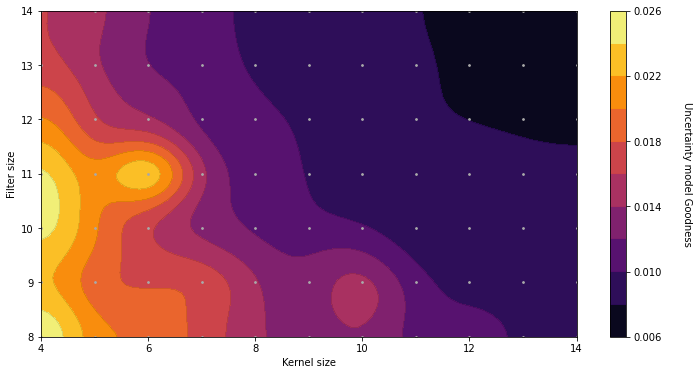

In [8]:
import scipy.ndimage
import matplotlib.tri as tri
from scipy.ndimage.filters import gaussian_filter

z=df['ID_MSE'].values
x=df['params_Kernel'].values
y=df['params_Filter'].values

fig, (ax1) = plt.subplots(nrows=1,figsize=(12,6))

npoints=77
smooth=4

# Create grid values first.
xi = np.linspace(x.min(), x.max(), npoints)
yi = np.linspace(y.min(), y.max(), npoints)

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

zi = gaussian_filter(zi, smooth)

levels=10

ax1.contour(xi, yi, zi, levels=levels, linewidths=0.1, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=levels, cmap="inferno",alpha=0.99)

cbar = plt.colorbar(cntr1, ax=ax1)

cbar.set_label('Uncertainty model Goodness', rotation=270,labelpad=30)

ax1.set(xlim=(df.params_Kernel.min(),
              df.params_Kernel.max()),
        ylim=(df.params_Filter.min(),
              df.params_Filter.max()))
ax1.scatter(x,y,s=3,color='darkgray')
ax1.set_ylabel('Filter size')
ax1.set_xlabel('Kernel size')
plt.savefig("{0}.png".format(StudyName), dpi=150,bbox_inches='tight')

plt.show()




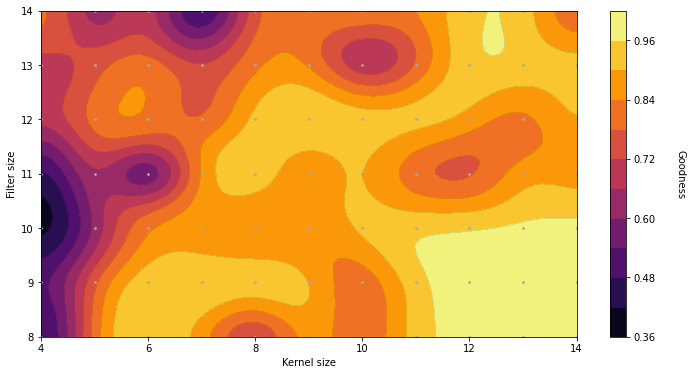

In [9]:
import scipy.ndimage
import matplotlib.tri as tri
from scipy.ndimage.filters import gaussian_filter

z=df['ID_G'].values
x=df['params_Kernel'].values
y=df['params_Filter'].values

fig, (ax1) = plt.subplots(nrows=1,figsize=(12,6))

npoints=77
smooth=4

# Create grid values first.
xi = np.linspace(x.min(), x.max(), npoints)
yi = np.linspace(y.min(), y.max(), npoints)

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

zi = gaussian_filter(zi, smooth)

levels=10

ax1.contour(xi, yi, zi, levels=levels, linewidths=0.1, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=levels, cmap="inferno",alpha=0.99)

cbar = plt.colorbar(cntr1, ax=ax1)

cbar.set_label('Goodness', rotation=270,labelpad=30)

ax1.set(xlim=(df.params_Kernel.min(),
              df.params_Kernel.max()),
        ylim=(df.params_Filter.min(),
              df.params_Filter.max()))
ax1.scatter(x,y,s=3,color='darkgray')
ax1.set_ylabel('Filter size')
ax1.set_xlabel('Kernel size')
plt.savefig("Goodness-{0}.png".format(StudyName), dpi=150,bbox_inches='tight')

plt.show()




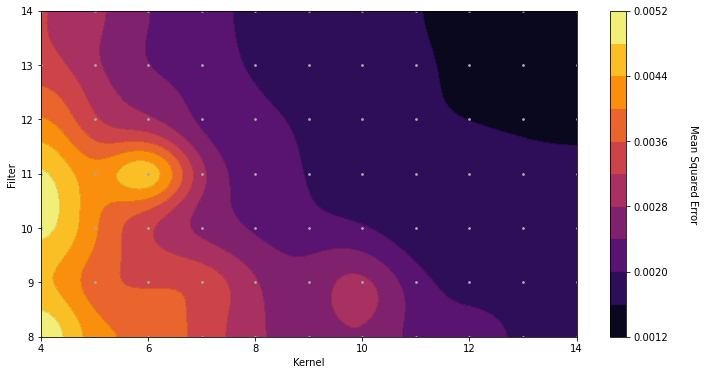

In [10]:
import scipy.ndimage
import matplotlib.tri as tri
from scipy.ndimage.filters import gaussian_filter

z=df['ID_MSE'].values
x=df['params_Kernel'].values
y=df['params_Filter'].values

fig, (ax1) = plt.subplots(nrows=1,figsize=(12,6))

npoints=77
smooth=4

# Create grid values first.
xi = np.linspace(x.min(), x.max(), npoints)
yi = np.linspace(y.min(), y.max(), npoints)

# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
interpolator = tri.LinearTriInterpolator(triang, z)
Xi, Yi = np.meshgrid(xi, yi)
zi = interpolator(Xi, Yi)

zi = gaussian_filter(zi, smooth)

levels=10

ax1.contour(xi, yi, zi, levels=levels, linewidths=0.1, colors='k')
cntr1 = ax1.contourf(xi, yi, zi, levels=levels, cmap="inferno",alpha=0.99)

cbar = plt.colorbar(cntr1, ax=ax1)

cbar.set_label('Mean Squared Error', rotation=270,labelpad=30)

ax1.set(xlim=(df.params_Kernel.min(),
              df.params_Kernel.max()),
        ylim=(df.params_Filter.min(),
              df.params_Filter.max()))
ax1.scatter(x,y,s=3,color='darkgray')
ax1.set_ylabel('Filter')
ax1.set_xlabel('Kernel')
plt.savefig("MSE-{0}.png".format(StudyName), dpi=150,bbox_inches='tight')

plt.show()




## Single model analysis

In [36]:
def make_gaussian_2d_kernel(sigma, truncate=4.0, dtype=tf.float32):
    radius = tf.cast(sigma * truncate,tf.int32)
    x = tf.cast(tf.range(-radius, radius + 1), dtype=dtype)
    k = tf.exp(-0.5 * tf.square(x / sigma))
    k = k / tf.reduce_sum(k)
    return tf.expand_dims(k, 1) * k

def gaussian_filter(image,sigma):
# Input data
#image = tf.placeholder(tf.float32, [16, 96, 96, 3])
# Convolution kernel
    kernel = make_gaussian_2d_kernel(sigma)

    kernel = tf.tile(kernel[:, :, tf.newaxis, tf.newaxis], [1, 1, 2, 1])
    image_filtered = tf.nn.separable_conv2d(image, kernel, 
                                            tf.eye(2, batch_shape=[1, 1]),
                                            strides=[1, 1, 1, 1], padding='SAME')
    return image_filtered

def custom_loss(y_actual,y_pred):
    K1 = 0.01
    K2 = 0.03
    sigma = 1.5 #Defined as 1.5
    dmax=1
    dmin=-1
    data_range = dmax - dmin
    R = data_range
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2
    cov_norm = 1.0
    #win_size = 7
    ux = gaussian_filter(y_actual,sigma)
    uy = gaussian_filter(y_pred,sigma)
    uxx = gaussian_filter(y_actual * y_actual,sigma)
    uyy = gaussian_filter(y_pred * y_pred,sigma)
    uxy = gaussian_filter(y_actual * y_pred,sigma)
    
    vx = cov_norm * (uxx - ux * ux)
    vy = cov_norm * (uyy - uy * uy)
    vxy = cov_norm * (uxy - ux * uy)

    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    
    D = B1 * B2
    S = (A1 * A2) / D

    # to avoid edge effects will ignore filter radius strip around edges
    #pad = (win_size - 1) // 2

    # compute (weighted) mean of ssim
    #mssim = crop(S, pad).mean()
    #mssim = tf.math.reduce_mean(S)
    mssim = tf.math.reduce_mean(S)
    loss2=tf.keras.losses.MAE(y_actual,y_pred)
    #total=0.5*(1-mssim)+0.5*(loss2)
    total=(1-mssim)+(loss2)
#    total=(1-mssim)
    return total

def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = (target.get_shape()[2] - refer.get_shape()[2])  #.value
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw / 2), int(cw / 2) + 1
    else:
        cw1, cw2 = int(cw / 2), int(cw / 2)
    # height, the 2nd dimension
    ch = (target.get_shape()[1] - refer.get_shape()[1])  #.value
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch / 2), int(ch / 2) + 1
    else:
        ch1, ch2 = int(ch / 2), int(ch / 2)

    return (ch1, ch2), (cw1, cw2)

def conv2d_block(input_tensor, n_filters, kernel_size, batchnorm):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x1 = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    # second layer
    x2 = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x1)
    if batchnorm:
        x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    return x2

def create_model(img_shape, num_class, dropout, kernel_size, n_filters, batchnorm):

    concat_axis = 3
    inputs =  Input(shape = img_shape)

    conv1 = conv2d_block(inputs, n_filters * 1, kernel_size, batchnorm = batchnorm)
    #conv1 =  Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same')(inputs)
    #conv1 =  Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same')(conv1)
    pool1 =  MaxPooling2D(pool_size=(2, 2))(conv1)
    #pool1 =  Dropout(dropout,seed=1991)(pool1,training=True)
    
    #conv2 =  Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same')(pool1)
    #conv2 =  Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same')(conv2)
    conv2 = conv2d_block(pool1, n_filters * 2, kernel_size, batchnorm = batchnorm)
    pool2 =  MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 =  Dropout(dropout,seed=4)(pool2,training=True)
    
    #conv3 =  Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same')(pool2)
    #conv3 =  Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same')(conv3)
    conv3 = conv2d_block(pool2, n_filters * 4, kernel_size, batchnorm = batchnorm)
    pool3 =  MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 =  Dropout(dropout,seed=1991)(pool3,training=True)

    #conv4 =  Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same')(pool3)
    #conv4 =  Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same')(conv4)
    conv4 = conv2d_block(pool3, n_filters * 8, kernel_size, batchnorm = batchnorm)
    pool4 =  MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 =  Dropout(dropout,seed=1991)(pool4,training=True)

    #conv5 =  Conv2D(512, (kernel_size, kernel_size), activation='relu', padding='same')(pool4)
    #conv5 =  Conv2D(512, (kernel_size, kernel_size), activation='relu', padding='same')(conv5)
    conv5 = conv2d_block(pool4, n_filters * 16, kernel_size, batchnorm = batchnorm)
    
    up_conv5 =  UpSampling2D(size=(2, 2))(conv5)
    ch, cw = get_crop_shape(conv4, up_conv5)
    crop_conv4 =  Cropping2D(cropping=(ch,cw))(conv4)
    up6 =  concatenate([up_conv5, crop_conv4], axis=concat_axis)
    up6=Dropout(dropout,seed=1991)(up6,training=True)
    #conv6 =  Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same')(up6)
    #conv6 =  Conv2D(256, (kernel_size, kernel_size), activation='relu', padding='same')(conv6)
    conv6 = conv2d_block(up6, n_filters * 8, kernel_size, batchnorm = batchnorm)
    
    up_conv6 =  UpSampling2D(size=(2, 2))(conv6)
    ch, cw = get_crop_shape(conv3, up_conv6)
    crop_conv3 =  Cropping2D(cropping=(ch,cw))(conv3)
    up7 =  concatenate([up_conv6, crop_conv3], axis=concat_axis) 
    up7=Dropout(dropout,seed=1991)(up7,training=True)
    #conv7 =  Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same')(up7)
    #conv7 =  Conv2D(128, (kernel_size, kernel_size), activation='relu', padding='same')(conv7)
    conv7 = conv2d_block(up7, n_filters * 4, kernel_size, batchnorm = batchnorm)

    up_conv7 =  UpSampling2D(size=(2, 2))(conv7)
    ch, cw = get_crop_shape(conv2, up_conv7)
    crop_conv2 =  Cropping2D(cropping=(ch,cw))(conv2)
    up8 =  concatenate([up_conv7, crop_conv2], axis=concat_axis)
    up8=Dropout(dropout,seed=1991)(up8,training=True)
    #conv8 =  Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same')(up8)
    #conv8 =  Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same')(conv8)
    conv8 = conv2d_block(up8, n_filters * 2, kernel_size, batchnorm = batchnorm)

    up_conv8 =  UpSampling2D(size=(2, 2))(conv8)
    ch, cw = get_crop_shape(conv1, up_conv8)
    crop_conv1 =  Cropping2D(cropping=(ch,cw))(conv1)
    up9 =  concatenate([up_conv8, crop_conv1], axis=concat_axis)
    up9=Dropout(dropout,seed=1991)(up9,training=True)
    #conv9 =  Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same')(up9)
    #conv9 =  Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same')(conv9)
    conv9 = conv2d_block(up9, n_filters * 1, kernel_size, batchnorm = batchnorm)

    ch, cw = get_crop_shape(inputs, conv9)
    conv9 =  ZeroPadding2D(padding=((ch[0], ch[1]), (cw[0], cw[1])))(conv9)
    conv10 =  Conv2D(num_class, (1, 1), activation='sigmoid')(conv9)
    #conv10 =  Conv2D(num_class, (1, 1), activation='relu')(conv9)
    model = Model(inputs=inputs, outputs=conv10)

    return model

In [42]:
#Randomly sample from the 400 cases
def get_cases(y_test, X_test, n_cases):
    np.random.seed(1)
    idx = np.random.choice(y_test.shape[0], n_cases, replace=False)
    y_s = y_test[idx, :, :, :]
    X_s = X_test[idx, :, :, :]
    return y_s, X_s


def evaluate_cases(model, X_s, batch_size):
    #Take n_samples to draw a distribution
    n_samples = 200
    mc_predictions = np.zeros((n_samples, X_s.shape[0], im_width, im_height))
    for i in range(n_samples):
        #y_p = mc_model.predict(X_test, batch_size=4)
        y_p = model.predict(X_s, verbose=1, batch_size=batch_size)
        mc_predictions[i] = (y_p[:, :, :, 0])
    tf.keras.backend.clear_session()
    return mc_predictions


def get_dataframe(mc_predictions, y_s, X_s):
    # Perform volumetric calculations
    Lx = 3280 / 2  #ft
    Dx = Lx / im_width
    Ly = 3280 / 2  #ft
    Dy = Lx / im_height
    Lz = 32.8  #ft
    Swi = 0.2
    Soi = 1 - Swi
    ft_bl = (28.3168 / 159)  #cubic ft to barrels
    Vp = Dx * Dy * Lz * (X_s[:, :, :, 0]) * ft_bl  # in bl
    OOIP = Vp * (1 - Swi)
    OWIP = Vp * (Swi)

    TruthSo = 1 - y_s[:, :, :, 0]
    PredSo = 1 - mc_predictions[:, :, :, :]

    #TruthWV=Vp*y_s[:,:,:,0]
    #PredWV=Vp*mc_predictions[:,:,:,:]

    TruthROV = Vp * TruthSo  #Residual oil volume in the reservoir truth
    PredROV = Vp * PredSo  #Residual oil volume in the reservoir estimated

    #Np_t=(OOIP-TruthROV)
    #Np_p=(OOIP-PredROV)

    #RF_t=(OOIP-TruthROV)/OOIP
    #RF_p=(OOIP-PredROV)/OOIP

    #Wi_t=(TruthWV-OWIP)
    #Wi_p=(PredWV-OWIP)

    Np = np.zeros(OOIP.shape[0])
    Np_pred = np.zeros((PredROV.shape[0], OOIP.shape[0]))
    Diff = np.zeros((PredROV.shape[0], OOIP.shape[0]))
    STD_u = np.zeros(OOIP.shape[0])
    Var_RF = np.zeros(OOIP.shape[0])
    TruthRF = np.zeros(OOIP.shape[0])
    PredRF = np.zeros((PredROV.shape[0], OOIP.shape[0]))
    avg_dif = np.zeros(OOIP.shape[0])
    Min_u = np.zeros(OOIP.shape[0])
    Max_u = np.zeros(OOIP.shape[0])
    Range = np.zeros(OOIP.shape[0])
    Var_Np = np.zeros(OOIP.shape[0])
    MeanNp = np.zeros(OOIP.shape[0])
    MeanRec = np.zeros(OOIP.shape[0])
    MeanPred = np.zeros(OOIP.shape[0])

    for i in range(OOIP.shape[0]):
        for j in range(PredROV.shape[0]):
            Np_pred[j,
                    i] = (np.sum(OOIP[i, :, :]) - np.sum(PredROV[j, i, :, :]))
            #Diff[j, i] = (Np_pred[j, i] - Np[i])
            PredRF[j,
                   i] = (np.sum(OOIP[i, :, :]) -
                         np.sum(PredROV[j, i, :, :])) / np.sum(OOIP[i, :, :])

        #Min_u[i] = np.min(Np_pred[:, i])
        #Max_u[i] = np.max(Np_pred[:, i])
        #MeanNp[i]=np.average(Np_pred[:,i])
        MeanRec[i] = np.average(PredRF[:, i])
        MeanPred[i] = np.average(Np_pred[:, i])
        #Range[i] = np.ptp(Diff[:, i])
        Np[i] = (np.sum(OOIP[i, :, :]) - np.sum(TruthROV[i, :, :]))
        TruthRF[i] = (np.sum(OOIP[i, :, :]) -
                      np.sum(TruthROV[i, :, :])) / np.sum(OOIP[i, :, :])
        STD_u[i] = np.std(Np_pred[:, i])
        Var_RF[i] = np.var(PredRF[:, i])
        Var_Np[i] = np.var(Np_pred[:, i])
        #avg_dif[i] = np.average(Diff[:, i])

    ## For Np
    xline = [0, 1000000]
    yline = [0, 1000000]
    plt.figure(figsize=(8, 5))
    #plt.plot(Np_pred[0,:],Np,'ko',label='Correlation coefficient = ');
    plt.errorbar(MeanPred, Np, xerr=STD_u, fmt='k.', ecolor='k')
    plt.plot(xline, yline, '-k')
    #plt.title(
#        'Cumulative oil production and error bars from Monte Carlo dropout')
    plt.xlabel('Predicted value, $\hat{y}$ [bl]')
    plt.ylabel('True value, $y$ [bl]')
    #plt.legend(loc='best');
    plt.show()

    Sw_avg = []
    for i in range(mc_predictions.shape[0]):
        Sw_avg.append(np.average(mc_predictions[i, 9, :, :]))

    std_Sw = np.std(Sw_avg)

    # Histograms
    n_bins = 20
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    N, bins, patches = axs.hist(Sw_avg,
                                bins=n_bins,
                                label='$\sigma$ = %2.5f' % std_Sw)
    #axs.set_title('Root Mean squared error in barrels for each cell');
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        #color = plt.cm.YlGnBu(norm(thisfrac))
        color = plt.cm.binary(norm(thisfrac))
        thispatch.set_facecolor(color)
    plt.legend()
    plt.ylabel('Number of cases')
    plt.xlabel('MSE in water saturation')

    stdNp = np.std(Np_pred[:, 9])
    n_bins = 20
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    N, bins, patches = axs.hist(Np_pred[:, 9],
                                bins=n_bins,
                                label='$\sigma$ = %2.2f barrels' % stdNp)
    #axs.set_title('Root Mean squared error in barrels for each cell');
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        #color = plt.cm.YlGnBu(norm(thisfrac))
        color = plt.cm.binary(norm(thisfrac))
        thispatch.set_facecolor(color)
    #plt.xlim(2000,8000)
    plt.legend()
    plt.ylabel('Number of cases')
    plt.xlabel('Predicted cumulative volume')

    df = pd.DataFrame()
    #df['PredRF']=PredRF[25,:]MeanRec
    df['PredRF'] = MeanRec[:]
    df['TruthRF'] = TruthRF
    df['Var_RF'] = Var_RF
    df['Var_Np'] = Var_Np
    df['Np_pred'] = Np_pred[0, :]
    df['Np'] = Np

    df.head()
    return df


def get_GAP(df, sk_estimate, sk_var, true_value, n_quantiles):
    F = np.zeros(
        (len(df),
         ))  # it will store the probabilities associated to the true values z
    # it will store the indicator function results
    indicator_func = np.zeros((len(df), n_quantiles))
    #     perc = np.arange(0.01, 1.00, 0.01)
    perc = np.linspace(0.01, 1.00, n_quantiles)
    # range of symmetric p-probability intervals
    plow = (1 - perc) / 2
    pupp = (1 + perc) / 2

    # column vector with all the sk standard deviation
    std = np.sqrt(df[sk_var])

    # F(u;z(u)|n(u))
    for index in range(len(df)):
        F[index] = stats.norm.cdf(df.loc[index, true_value],
                                  loc=df.loc[index, sk_estimate],
                                  scale=std[index])

    # for each value of F, compute the indicator function
    for index, f in enumerate(F):
        indicator_func[index] = np.array([
            1 if proba_low < f <= proba_upp else 0
            for proba_low, proba_upp in zip(plow, pupp)
        ])

    print(f'Overall uncertainty = {df[sk_var].mean():.6f}')
    U = df[sk_var].mean()
    IF = indicator_func
    ##% Goodness, Precision and Accuracy
    #a(p) is the indicator function IF
    #     perc=np.arange(0.0,1.00,0.01)
    #     G=(3*IF-2)*(np.mean(IF,axis=0)-perc)
    #     G=G[1,:]
    #     g=InterpolatedUnivariateSpline(perc,G,k=1.00)
    #     P=IF*((np.mean(IF,axis=0)-perc))
    #     P=P[1,:]
    #     p=InterpolatedUnivariateSpline(perc,G,k=1.00)
    #     A=IF[1,:]
    #     a=InterpolatedUnivariateSpline(perc,A,k=1.00)
    #     Accuracy=a.integral(0,1)
    #     Goodness=1-g.integral(0,1)
    #     Precision= 1-2*p.integral(0,1)
    AvgG = 0
    AvgP = 0
    AvgA = 0
    for i in range(IF.shape[0]):
        G = (3 * IF - 2) * (np.mean(IF, axis=0) - perc)
        G = G[i, :]
        g = InterpolatedUnivariateSpline(perc, G, k=1.00)
        P = IF * ((np.mean(IF, axis=0) - perc))
        P = P[i, :]
        p = InterpolatedUnivariateSpline(perc, G, k=1.00)
        A = IF[i, :]
        a = InterpolatedUnivariateSpline(perc, A, k=1.00)
        Accuracy = a.integral(0, 1)
        Precision = 1 - 2 * p.integral(0, 1)
        Goodness = 1 - g.integral(0, 1)

        if Goodness > 1:
            Goodness = 1
        if Goodness < 0:
            Goodness = 0
        if Accuracy > 1:
            Accuracy = 1
        if Accuracy < 0:
            Accuracy = 0
        if Precision > 1:
            Precision = 1
        if Precision < 0:
            Precision = 0

        AvgG = AvgG + Goodness
        AvgP = AvgP + Precision
        AvgA = AvgA + Accuracy

    AvgG = AvgG / int(IF.shape[0])
    AvgP = AvgP / int(IF.shape[0])
    AvgA = AvgA / int(IF.shape[0])
    #AvgG=AvgG/int(IF.shape[0]+IF.shape[1])
    #AvgP=AvgP/int(IF.shape[0]+IF.shape[1])
    #AvgA=AvgA/int(IF.shape[0]+IF.shape[1])

    ###################################
    #     Bootstrap for uncertainty
    ###################################
    L = 100  # number of realizations changed from 2000
    mean = np.empty((L, len(perc)))
    std = np.empty_like(mean)
    for p_interv in range(len(perc)):
        for l in np.arange(0, L):
            samples = random.choices(indicator_func[:, p_interv],
                                     k=indicator_func.shape[0])
            mean[l, p_interv] = np.mean(samples)

    plt.figure(figsize=(10, 6))
    plt.plot(perc,
                np.round(np.std(mean, axis=0)+np.mean(indicator_func, axis=0), 3),
            '--k')
    plt.plot(perc,
             np.round(np.mean(indicator_func, axis=0), 3),
             '-ok',
            markersize=2)
    plt.plot(perc,
             np.round(np.mean(indicator_func, axis=0)-np.std(mean, axis=0), 3),
             '--k')
    plt.plot([0, 1],
             [0, 1],'-k')
    plt.ylabel(r'$\xi (p)$')
    plt.xlabel('Probability interval $p$')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.show()

    return AvgG, AvgP, AvgA, U  #Goodness,Precision,Accuracy

In [40]:
#load the best model

batch_size=8
dropout=0.85#trial.suggest_discrete_uniform('Dropout', 0.05, 0.95, 0.01)
kernel_size=14
epochs=22 #22
learning_rate=0.00013#float(trial.suggest_discrete_uniform('learn_rate',0.0001, .0002 , 0.00001))
n_filters=13

model = create_model(
    img_shape,
    num_class,
    dropout=dropout,
    #kernel_size=7,
    kernel_size=kernel_size,
    #n_filters=9,
    n_filters=n_filters,
    batchnorm=False)

opt = Adam(lr=learning_rate)
#     model.compile(loss='binary_crossentropy', #
#                   optimizer=opt,
#                   metrics=['accuracy'])
model.compile(
    loss=custom_loss,  #
    optimizer=opt,
    metrics=['mse','mae'])

#model.load_weights('unet-multiple-output.h5')
#model.load_weights('k9_f16_2pos_noP_best!.h5')
#model.load_weights('k8_f16_2pos_noP.h5') #This one performs pretty well!
#model.load_weights('k24_f8_1pos.h5')
#model.load_weights('k7_f16_2pos.h5')
#model.load_weights('k5_f16_2pos_S.h5')
model.load_weights('14-13.h5')



31/31 [==============================] - 0s 12ms/step
==========================ID=============================


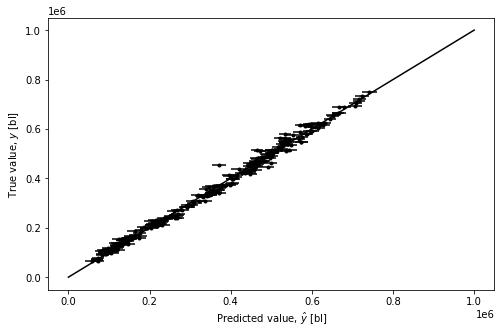

Overall uncertainty = 0.000114


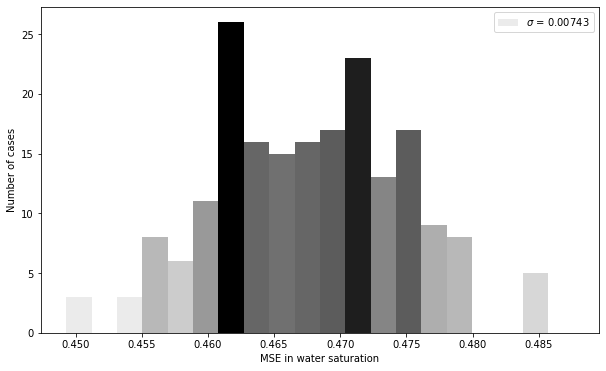

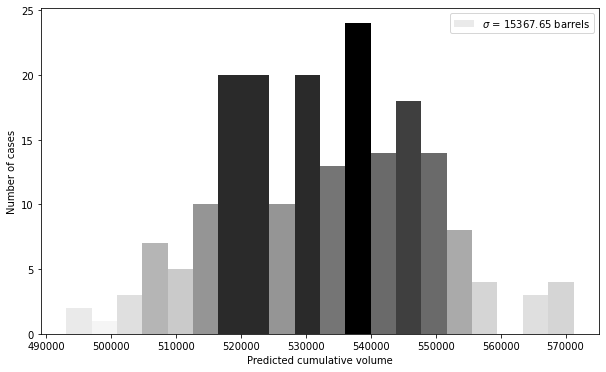

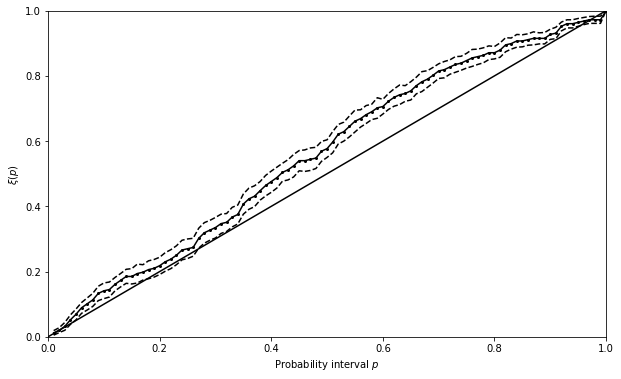

50/50 [==============================] - 1s 13ms/step


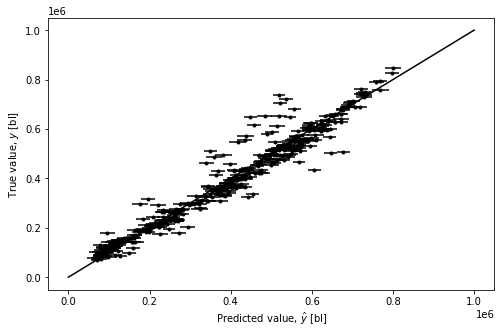

==========================OOD=============================
Overall uncertainty = 0.000120


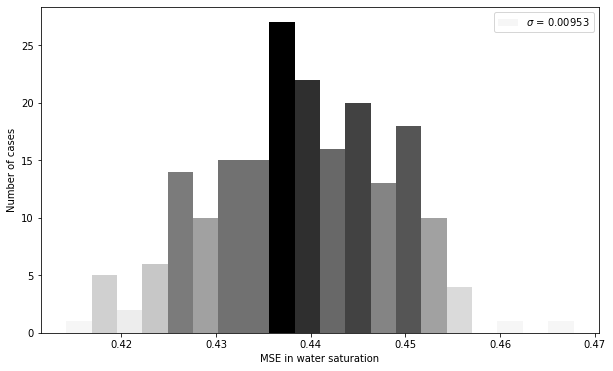

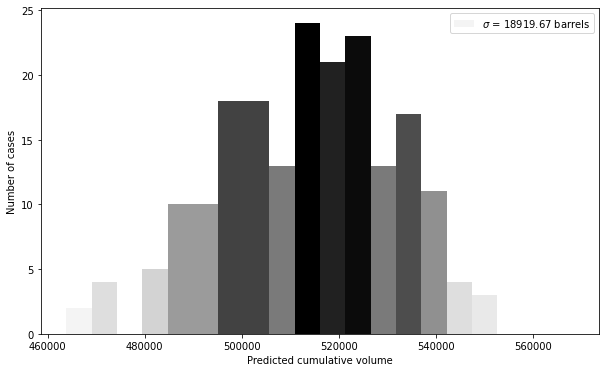

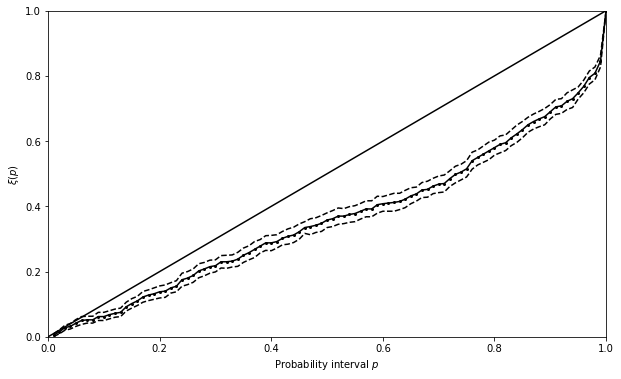

The goodness is 0.88
The precision is 0.76
The accuracy is 0.363


SyntaxError: 'return' outside function (<ipython-input-44-db16c51f44f6>, line 40)

In [44]:
# Evaluate the model accuracy on the validation set.
# ===========Inside distribution===================
score_ID = model.evaluate(X_test_ID, y_test_ID, verbose=0)
#score1 = model.evaluate(X_test, y_test, verbose=0)

mc_predictions = evaluate_cases(model, X_test_ID,batch_size)
print('==========================ID=============================')
df_ID = get_dataframe(mc_predictions, y_test_ID, X_test_ID)
AvgG, AvgP, AvgA, U = get_GAP(df_ID,
                           'PredRF',
                           'Var_RF',
                           'TruthRF',
                           n_quantiles=100)

#    if AvgG>0.7:
#        Score = (score[1]/AvgG)*U  #+AvgP+AvgA
#else:
    #Score=0.001
#Score = (score[1]/AvgG)  #+AvgP+AvgA
Score=AvgG
    
score_OOD = model.evaluate(X_test, y_test, verbose=0)

#score1 = model.evaluate(X_test, y_test, verbose=0)

mc_predictions = evaluate_cases(model, X_test,batch_size)
df = get_dataframe(mc_predictions, y_test, X_test)
print('==========================OOD=============================')
AvgG, AvgP, AvgA, U = get_GAP(df,
                           'PredRF',
                           'Var_RF',
                           'TruthRF',
                           n_quantiles=100)

Score=AvgG

print(f'The goodness is {AvgG:.3}')
print(f'The precision is {AvgP:.3}')
print(f'The accuracy is {AvgA:.3}')
#return Score  #score[1]

In [45]:
def get_GAP(MeanVal, Sigma, Truth, n_quantiles):
    '''
    This function takes the dataframe and calculates the indicator function and the average
    we then use this information to estimate the accuracy, goodness and precision of the model.
    '''
    perc = np.linspace(0.0, 1.00, n_quantiles)
    F = np.zeros(MeanVal.shape[0])
    Indicator_func = np.zeros((MeanVal.shape[0], perc.shape[0]))

    # range of symmetric p-probability intervals
    plow = (1 - perc) / 2
    pupp = (1 + perc) / 2
        
    for i in range(len(MeanVal)):
        F[i] = stats.norm.cdf(Truth[i],
                              loc=MeanVal[i],
                              scale=Sigma[i])
        for proba_low, proba_upp in zip(plow, pupp):
            for k in range(len(plow)):
                if plow[k] < F[i] <= pupp[k]:
                    Indicator_func[i, k] = 1
                else:
                    Indicator_func[i, k] = 0

    avgIndFunc = np.mean(Indicator_func, axis=0)
    
    a = np.zeros(len(avgIndFunc))
    for i in range(len(avgIndFunc)):
        if avgIndFunc[i] > perc[i] or avgIndFunc[i] == perc[i]:
            a[i] = 1
        else:
            a[i] = 0
    print(f'Overall uncertainty = {Sigma.mean():.6f}')
    U = Sigma.mean()
    
    ##% Goodness, Precision and Accuracy
    

    Accuracy = integrate.simps(a, perc)

    Prec = a*(avgIndFunc-perc)
    Precision = 1-2*integrate.simps(Prec, perc)

    Sum = (3*a-2)*(avgIndFunc-perc)
    Goodness = 1-integrate.simps(Sum, perc)

    return Goodness, Precision, Accuracy, U, Indicator_func,perc

def error_line(Mean,Truth,STD,r):
    '''
    Simple function to draw an error line plot. It takes the mean predicted value,
    the truth value and the standard deviation.
    '''
    
    xline = [0,1]#
    yline = [0,1]#
    plt.figure(figsize=(10, 6))
    mask = np.random.choice([False, True], len(Mean), p=[0.0, 1])
    plt.errorbar(Mean[mask], Truth[mask], xerr=STD[mask], 
                 fmt='k.',
                 ecolor='k')#,
                 #label="Pearson's r = {0:2.2f}".format(r))
    #plt.legend()
    plt.plot(xline, yline, '-k')
    
    plt.xlabel('Predicted value, $\hat{y}$')
    plt.ylabel('True value, $y$ ')

    plt.show()
    
def accuracy_plot(Indicator_func,perc):
    '''
    This function takes the indicator function and percentiles to draw the accuracy plot.
    '''
    
    L = 100  
    mean = np.empty((L, len(perc)))
    std = np.empty_like(mean)
    avgIndFunc = np.mean(Indicator_func, axis=0)
    for p_interv in range(len(perc)):
        for l in np.arange(0, L):
            samples = random.choices(Indicator_func[:, p_interv],
                                     k=Indicator_func.shape[0])
            mean[l, p_interv] = np.mean(samples)

    plt.figure(figsize=(10, 6))
    plt.plot(perc, avgIndFunc,'-ok',markersize=5)
    plt.plot(perc,np.round(avgIndFunc+np.std(mean, axis=0), 3),'--k')
    plt.plot(perc,np.round(avgIndFunc-np.std(mean, axis=0), 3),'--k')
    plt.plot([0, 1],[0, 1],'-k')
    plt.ylabel(r"$\overline{\xi (p)}$")
    plt.xlabel('Probability interval $p$')
    plt.ylim(0,1)
    plt.xlim(0,1)
    plt.show()

def histogram(mc_predictions):
    '''
    From the Monte Carlo predictions we draw a random point and construct the
    histogram of predictions from the model
    '''
    
    Avg = []
    rand=np.random.randint(0,mc_predictions.shape[1])
    for i in range(mc_predictions.shape[0]):
        Avg.append(np.average(mc_predictions[i,rand]))

    Std = np.std(Avg)

    # Histograms
    n_bins = 20
    fig, axs = plt.subplots(1, 1, figsize=(10, 6))
    N, bins, patches = axs.hist(Avg,
                                bins=n_bins,
                                label='$\sigma$ = %2.5f' % Std)
    #axs.set_title('Root Mean squared error in barrels for each cell');
    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())
    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.binary(norm(thisfrac))
        thispatch.set_facecolor(color)
    plt.legend()
    plt.ylabel('Number of cases')
    plt.xlabel('MSE in predicted value')
    
def plot_loss(history):
    '''
    Simple function to plot the loss for the training and testing data
    '''
    plt.figure(figsize=(12,6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Testing loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss ')
    plt.legend()
    plt.grid(True)    
    
def evaluate_cases(model, X_s, batch_size):
    #Take n_samples to draw a distribution
    n_samples = 200
    mc_predictions = np.zeros((n_samples, X_s.shape[0], im_width, im_height))
    for i in range(n_samples):
        #y_p = mc_model.predict(X_test, batch_size=4)
        y_p = model.predict(X_s, verbose=1, batch_size=batch_size)
        mc_predictions[i] = (y_p[:, :, :, 0])
    tf.keras.backend.clear_session()
    return mc_predictions
    
def get_dataframe(mc_predictions, y_s, X_s):
    # Perform volumetric calculations
    Lx = 3280 / 2  #ft
    Dx = Lx / im_width
    Ly = 3280 / 2  #ft
    Dy = Lx / im_height
    Lz = 32.8  #ft
    Swi = 0.2
    Soi = 1 - Swi
    ft_bl = (28.3168 / 159)  #cubic ft to barrels
    Vp = Dx * Dy * Lz * (X_s[:, :, :, 0]) * ft_bl  # in bl
    OOIP = Vp * (1 - Swi)
    OWIP = Vp * (Swi)

    TruthSo = 1 - y_s[:, :, :, 0]
    PredSo = 1 - mc_predictions[:, :, :, :]

    #TruthWV=Vp*y_s[:,:,:,0]
    #PredWV=Vp*mc_predictions[:,:,:,:]

    TruthROV = Vp * TruthSo  #Residual oil volume in the reservoir truth
    PredROV = Vp * PredSo  #Residual oil volume in the reservoir estimated

    Np = np.zeros(OOIP.shape[0])
    Np_pred = np.zeros((PredROV.shape[0], OOIP.shape[0]))
    Diff = np.zeros((PredROV.shape[0], OOIP.shape[0]))
    STD_u = np.zeros(OOIP.shape[0])
    Var_RF = np.zeros(OOIP.shape[0])
    TruthRF = np.zeros(OOIP.shape[0])
    PredRF = np.zeros((PredROV.shape[0], OOIP.shape[0]))
    avg_dif = np.zeros(OOIP.shape[0])
    Min_u = np.zeros(OOIP.shape[0])
    Max_u = np.zeros(OOIP.shape[0])
    Range = np.zeros(OOIP.shape[0])
    Var_Np = np.zeros(OOIP.shape[0])
    MeanNp = np.zeros(OOIP.shape[0])
    MeanRec = np.zeros(OOIP.shape[0])
    MeanPred = np.zeros(OOIP.shape[0])

    for i in range(OOIP.shape[0]):
        for j in range(PredROV.shape[0]):
            Np_pred[j,
                    i] = (np.sum(OOIP[i, :, :]) - np.sum(PredROV[j, i, :, :]))
            #Diff[j, i] = (Np_pred[j, i] - Np[i])
            PredRF[j,
                   i] = (np.sum(OOIP[i, :, :]) -
                         np.sum(PredROV[j, i, :, :])) / np.sum(OOIP[i, :, :])

        #Min_u[i] = np.min(Np_pred[:, i])
        #Max_u[i] = np.max(Np_pred[:, i])
        #MeanNp[i]=np.average(Np_pred[:,i])
        MeanRec[i] = np.average(PredRF[:, i])
        MeanPred[i] = np.average(Np_pred[:, i])
        #Range[i] = np.ptp(Diff[:, i])
        Np[i] = (np.sum(OOIP[i, :, :]) - np.sum(TruthROV[i, :, :]))
        TruthRF[i] = (np.sum(OOIP[i, :, :]) -
                      np.sum(TruthROV[i, :, :])) / np.sum(OOIP[i, :, :])
        STD_u[i] = np.std(Np_pred[:, i])
        Var_RF[i] = np.var(PredRF[:, i])
        Var_Np[i] = np.var(Np_pred[:, i])
        #avg_dif[i] = np.average(Diff[:, i])

#     ## For Np
#     xline = [0, 1000000]
#     yline = [0, 1000000]
#     plt.figure(figsize=(8, 5))
#     #plt.plot(Np_pred[0,:],Np,'ko',label='Correlation coefficient = ');
#     plt.errorbar(MeanPred, Np, xerr=STD_u * 2, fmt='k.', ecolor='k')
#     plt.plot(xline, yline, '-k')
#     #plt.title(
# #        'Cumulative oil production and error bars from Monte Carlo dropout')
#     plt.xlabel('Predicted value, $\hat{y}$ [bl]')
#     plt.ylabel('True value, $y$ [bl]')
#     #plt.legend(loc='best');
#     plt.show()

    Sw_avg = []
    for i in range(mc_predictions.shape[0]):
        Sw_avg.append(np.average(mc_predictions[i, 9, :, :]))

    std_Sw = np.std(Sw_avg)

#     # Histograms
#     n_bins = 20
#     fig, axs = plt.subplots(1, 1, figsize=(10, 6))
#     N, bins, patches = axs.hist(Sw_avg,
#                                 bins=n_bins,
#                                 label='$\sigma$ = %2.5f' % std_Sw)
#     #axs.set_title('Root Mean squared error in barrels for each cell');
#     fracs = N / N.max()
#     norm = colors.Normalize(fracs.min(), fracs.max())
#     for thisfrac, thispatch in zip(fracs, patches):
#         #color = plt.cm.YlGnBu(norm(thisfrac))
#         color = plt.cm.binary(norm(thisfrac))
#         thispatch.set_facecolor(color)
#     plt.legend()
#     plt.ylabel('Number of cases')
#     plt.xlabel('MSE in water saturation')

#     stdNp = np.std(Np_pred[:, 9])
#     n_bins = 20
#     fig, axs = plt.subplots(1, 1, figsize=(10, 6))
#     N, bins, patches = axs.hist(Np_pred[:, 9],
#                                 bins=n_bins,
#                                 label='$\sigma$ = %2.2f barrels' % stdNp)
#     #axs.set_title('Root Mean squared error in barrels for each cell');
#     fracs = N / N.max()
#     norm = colors.Normalize(fracs.min(), fracs.max())
#     for thisfrac, thispatch in zip(fracs, patches):
#         #color = plt.cm.YlGnBu(norm(thisfrac))
#         color = plt.cm.binary(norm(thisfrac))
#         thispatch.set_facecolor(color)
#     #plt.xlim(2000,8000)
#     plt.legend()
#     plt.ylabel('Number of cases')
#     plt.xlabel('Predicted cumulative volume')

    df = pd.DataFrame()
    #df['PredRF']=PredRF[25,:]MeanRec
    df['PredRF'] = MeanRec[:]
    df['TruthRF'] = TruthRF
    df['Var_RF'] = Var_RF
    df['Sigma_RF'] = np.sqrt(Var_RF)
    df['Var_Np'] = Var_Np
    df['Np_pred'] = Np_pred[0, :]
    df['Np'] = Np

    df.head()
    return df

### Train

In [46]:
#import timeit

#start = timeit.timeit()
mc_predictions = evaluate_cases(model, X_train,batch_size)
#end = timeit.timeit()


73/73 [==============================] - 1s 13ms/step


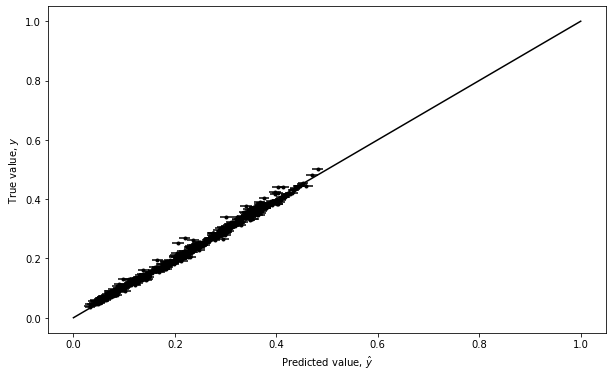

Overall uncertainty = 0.010647
Goodness =0.9 
Precision =0.9 
Accuracy =1.0


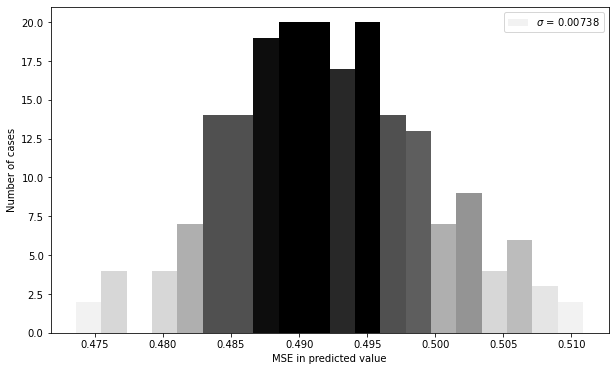

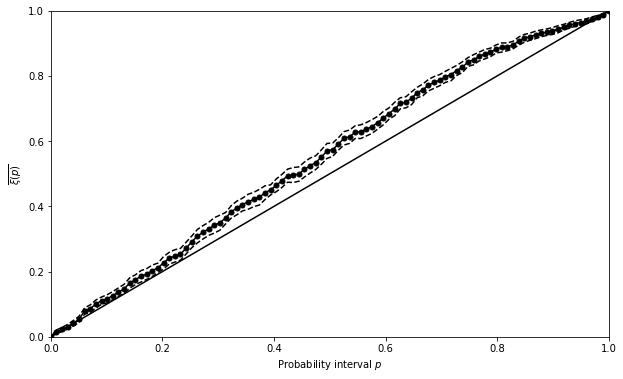

In [47]:
df = get_dataframe(mc_predictions, y_train, X_train)

r= stats.pearsonr(df.PredRF,df.TruthRF)
error_line(df.PredRF,df.TruthRF,df.Sigma_RF,r[0])
AvgG, AvgP, AvgA, U, IF, p = get_GAP(df.PredRF, df.Sigma_RF, df.TruthRF, n_quantiles=100)
print('Goodness ={0:1.1f} \nPrecision ={1:1.1f} \nAccuracy ={2:1.1f}'.format(AvgG, AvgP, AvgA))
histogram(mc_predictions)
accuracy_plot(IF,p)

### Test ID

In [48]:
mc_predictions = evaluate_cases(model, X_test_ID,batch_size)

31/31 [==============================] - 0s 13ms/step


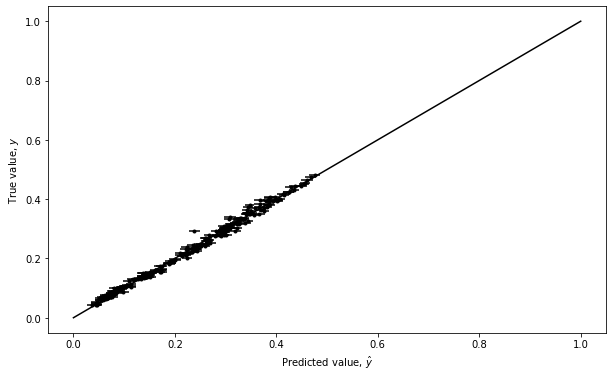

Overall uncertainty = 0.010626
Goodness =0.9 
Precision =0.9 
Accuracy =1.0


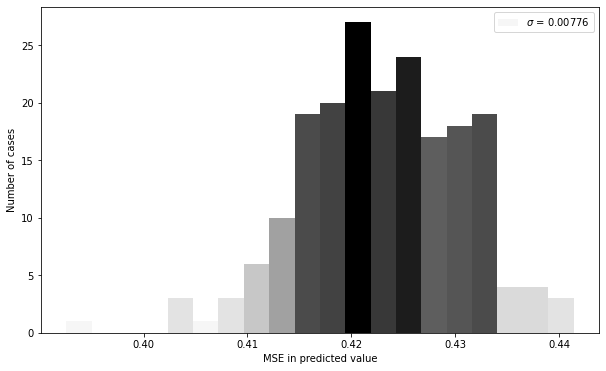

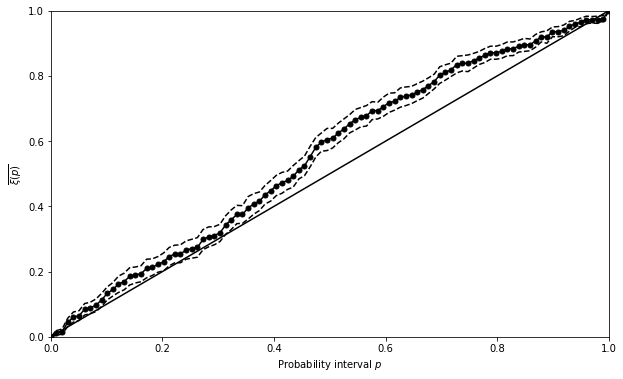

In [49]:
df = get_dataframe(mc_predictions, y_test_ID, X_test_ID)

r= stats.pearsonr(df.PredRF,df.TruthRF)
error_line(df.PredRF,df.TruthRF,df.Sigma_RF,r[0])
AvgG, AvgP, AvgA, U, IF, p = get_GAP(df.PredRF, df.Sigma_RF, df.TruthRF, n_quantiles=100)
print('Goodness ={0:1.1f} \nPrecision ={1:1.1f} \nAccuracy ={2:1.1f}'.format(AvgG, AvgP, AvgA))
histogram(mc_predictions)
accuracy_plot(IF,p)

### Test OD

In [50]:
mc_predictions = evaluate_cases(model, X_test,batch_size)

50/50 [==============================] - 1s 13ms/step


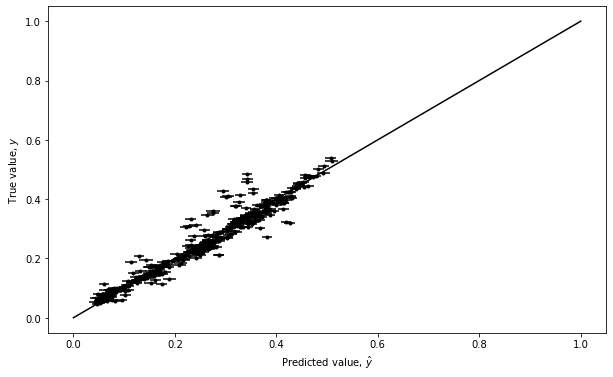

Overall uncertainty = 0.010909
Goodness =0.7 
Precision =1.0 
Accuracy =0.0


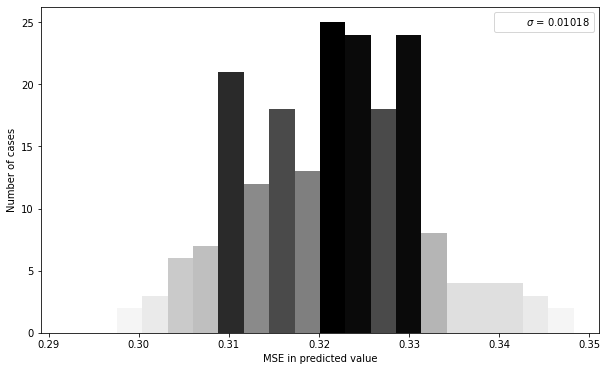

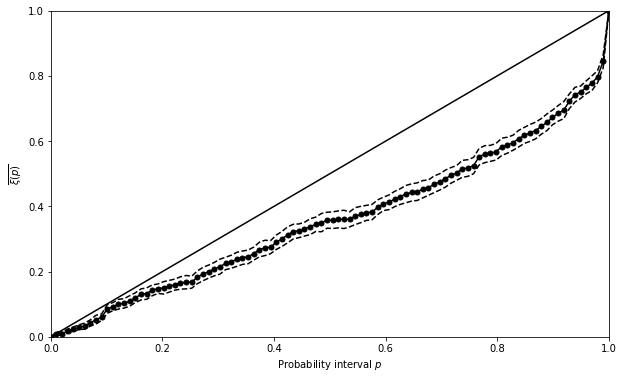

In [51]:
df = get_dataframe(mc_predictions, y_test, X_test)

r= stats.pearsonr(df.PredRF,df.TruthRF)
error_line(df.PredRF,df.TruthRF,df.Sigma_RF,r[0])
AvgG, AvgP, AvgA, U, IF, p = get_GAP(df.PredRF, df.Sigma_RF, df.TruthRF, n_quantiles=100)
print('Goodness ={0:1.1f} \nPrecision ={1:1.1f} \nAccuracy ={2:1.1f}'.format(AvgG, AvgP, AvgA))
histogram(mc_predictions)
accuracy_plot(IF,p)

## Summary statistics

In [52]:
preds_train = model.predict(X_train, verbose=1,batch_size=4)
preds_valid = model.predict(X_test_ID, verbose=1,batch_size=4)



62/62 [==============================] - 1s 13ms/step


In [53]:
preds_test = model.predict(X_test, verbose=1,batch_size=2)

200/200 [==============================] - 3s 13ms/step


In [54]:
def statistics(elem):
    Mean=np.mean(elem)
    print('The mean is %2.4f' %Mean)
    StdDev=np.std(elem)
    print('The standard deviation is %2.4f' %StdDev)
    Min=np.min(elem)
    print('The minimum element is %2.4f' %Min)
    Max=np.max(elem)
    print('The maximum element is %2.4f' %Max)
    Range=np.ptp(elem)
    print('The range is %2.4f' %Range)

### Train histograms

In [66]:
#ix=10
train_MSE=np.zeros(y_train.shape[0])
train_Score=np.zeros(y_train.shape[0])
for ix in range(y_train.shape[0]):
    score,diff,mse=mse_score_diff(y_train[ix,:,:,0],preds_train[ix,:,:,0])
    train_MSE[ix]=mse
    train_Score[ix]=score
    #print(score,err)

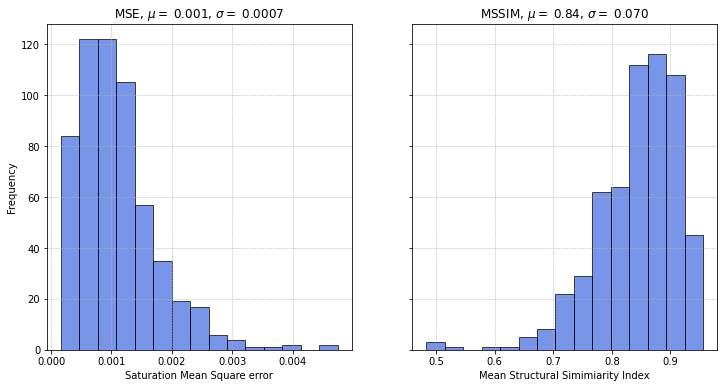

In [67]:
#import matplotlib
#matplotlib.rcParams.update({'font.size': 15})
n_bins=15
fig, axs = plt.subplots(1, 2, figsize=(12,6),sharey=True)

N, bins, patches = axs[0].hist(train_MSE, bins=n_bins,ec='black',fc='royalblue',alpha=0.7)
axs[0].set_title('MSE, $\mu = $ {0:.3f}, $\sigma = $ {1:.4f} '.format(np.mean(train_MSE),np.std(train_MSE)));
axs[0].set_xlabel('Saturation Mean Square error');
axs[0].set_ylabel('Frequency');
axs[0].grid(True,linestyle='--',linewidth=0.5)

N, bins, patches = axs[1].hist(train_Score, bins=n_bins, ec='black',fc='royalblue',alpha=0.7)
axs[1].set_title('MSSIM, $\mu = $ {0:.2f}, $\sigma = $ {1:.3f} '.format(np.mean(train_Score),np.std(train_Score)));
axs[1].set_xlabel('Mean Structural Simimiarity Index');
axs[1].grid(True,linestyle='--',linewidth=0.5)


plt.savefig('Histogram_train.png',bbox_inches="tight")

### Test histograms

In [68]:
#ix=10
test_MSE=np.zeros(y_test_ID.shape[0])
test_Score=np.zeros(y_test_ID.shape[0])
for ix in range(y_test_ID.shape[0]):
    score,diff,mse=mse_score_diff(y_test_ID[ix,:,:,0],preds_valid[ix,:,:,0])
    test_MSE[ix]=mse
    test_Score[ix]=score
    #print(score,err)

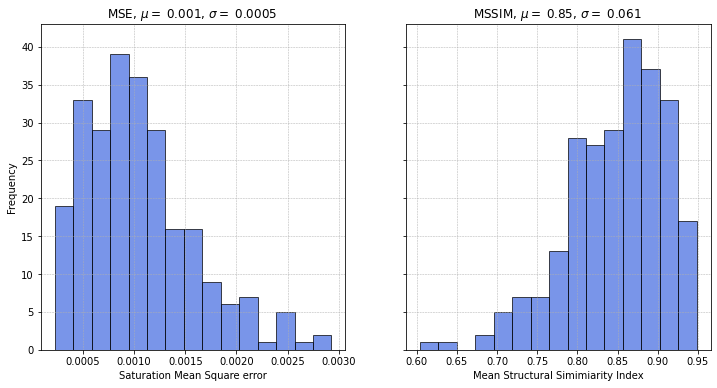

In [69]:
#import matplotlib
#matplotlib.rcParams.update({'font.size': 15})
n_bins=15
fig, axs = plt.subplots(1, 2, figsize=(12,6),sharey=True)

N, bins, patches = axs[0].hist(test_MSE, bins=n_bins,ec='black',fc='royalblue',alpha=0.7)
axs[0].set_title('MSE, $\mu = $ {0:.3f}, $\sigma = $ {1:.4f} '.format(np.mean(test_MSE),np.std(test_MSE)));
axs[0].set_xlabel('Saturation Mean Square error');
axs[0].set_ylabel('Frequency');
axs[0].grid(True,linestyle='--',linewidth=0.5)

N, bins, patches = axs[1].hist(test_Score, bins=n_bins, ec='black',fc='royalblue',alpha=0.7)
axs[1].set_title('MSSIM, $\mu = $ {0:.2f}, $\sigma = $ {1:.3f} '.format(np.mean(test_Score),np.std(test_Score)));
axs[1].set_xlabel('Mean Structural Simimiarity Index');
axs[1].grid(True,linestyle='--',linewidth=0.5)


plt.savefig('Histogram_test.png',bbox_inches="tight")

### Test_OD histogram

In [70]:
test_MSE=np.zeros(y_test.shape[0])
test_Score=np.zeros(y_test.shape[0])
for ix in range(y_test.shape[0]):
    score,diff,mse=mse_score_diff(y_test[ix,:,:,0],preds_test[ix,:,:,0])
    test_MSE[ix]=mse
    test_Score[ix]=score
    #print(score,err)

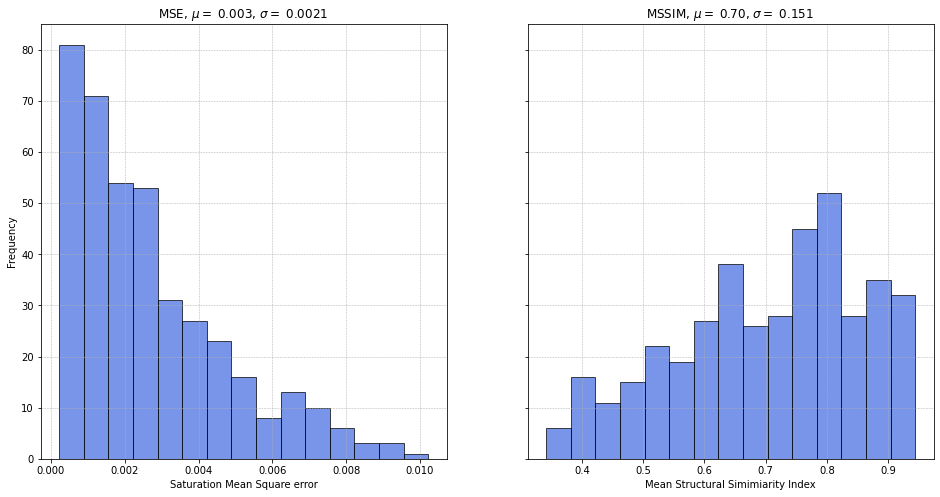

In [71]:
n_bins=15
fig, axs = plt.subplots(1, 2, figsize=(16,8),sharey=True)

N, bins, patches = axs[0].hist(test_MSE, bins=n_bins,ec='black',fc='royalblue',alpha=0.7)
axs[0].set_title('MSE, $\mu = $ {0:.3f}, $\sigma = $ {1:.4f} '.format(np.mean(test_MSE),np.std(test_MSE)));
axs[0].set_xlabel('Saturation Mean Square error');
axs[0].set_ylabel('Frequency');
axs[0].grid(True,linestyle='--',linewidth=0.5)

N, bins, patches = axs[1].hist(test_Score, bins=n_bins, ec='black',fc='royalblue',alpha=0.7)
axs[1].set_title('MSSIM, $\mu = $ {0:.2f}, $\sigma = $ {1:.3f} '.format(np.mean(test_Score),np.std(test_Score)));
axs[1].set_xlabel('Mean Structural Simimiarity Index');
axs[1].grid(True,linestyle='--',linewidth=0.5)


plt.savefig('Histogram_test_OD.png',bbox_inches="tight")

### Volume Calc

In [74]:
Lx=3280/2 #ft
Dx=Lx/32
Ly=3280/2 #ft
Dy=Lx/32
Lz=32.8   #ft
Swi=0.2
Soi=1-Swi
ft_bl=(28.3168/159) #cubic ft to barrels
Vp=Dx*Dy*Lz*(X_test[:,:,:,0])*ft_bl# in bl
OOIP=Vp*(1-Swi)
OWIP=Vp*(Swi)

TruthSo=1-y_test[:,:,:,0]
PredSo=1-preds_test[:,:,:,0]

TruthWV=Vp*y_test[:,:,:,0]
PredWV=Vp*preds_test[:,:,:,0]

TruthROV=Vp*TruthSo #Residual oil volume in the reservoir truth
PredROV=Vp*PredSo #Residual oil volume in the reservoir estimated

Np_t=(OOIP-TruthROV)
Np_p=(OOIP-PredROV)

RF_t=(OOIP-TruthROV)/OOIP
RF_p=(OOIP-PredROV)/OOIP

Wi_t=(TruthWV-OWIP)
Wi_p=(PredWV-OWIP)

In [75]:
TruthRF=np.zeros(OOIP.shape[0])
PredRF=np.zeros(OOIP.shape[0])
ATruthSo=np.zeros(OOIP.shape[0])
APredSo=np.zeros(OOIP.shape[0])
ATruthSw=np.zeros(OOIP.shape[0])
APredSw=np.zeros(OOIP.shape[0])
for ix in range(OOIP.shape[0]):
    TruthRF[ix],PredRF[ix]=volumetrics(OOIP[ix,:,:],TruthROV[ix,:,:],PredROV[ix,:,:])
    ATruthSo[ix]=np.average(TruthSo[ix,:,:])
    APredSo[ix]=np.average(PredSo[ix,:,:])
    ATruthSw[ix]=1-ATruthSo[ix]
    APredSw[ix]=1-APredSo[ix]

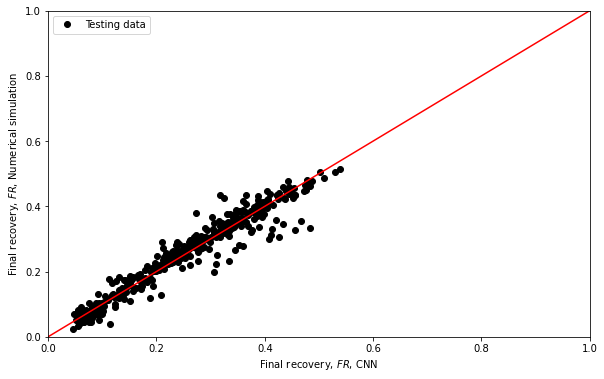

In [76]:
## For saturation 
xline=[0,1]
yline=[0,1]
plt.figure(figsize=(9.708,6)) 
plt.plot(TruthRF,PredRF,'ko',label='Testing data')
plt.plot(xline,yline,'-r')
plt.xlabel('Final recovery, $FR$, CNN')
plt.ylabel('Final recovery, $FR$, Numerical simulation')
plt.legend(loc='best')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show();
#plt.gca().invert_xaxis()
#plt.savefig("CrossValidation.png", bbox_inches="tight")

### Cross validation Production estimation

In [77]:
Np_pred=np.zeros(OOIP.shape[0])
Np=np.zeros(OOIP.shape[0])
for ix in range(OOIP.shape[0]):
    Np[ix]=(np.sum(OOIP[ix,:,:])-np.sum(TruthROV[ix,:,:]))
    Np_pred[ix]=(np.sum(OOIP[ix,:,:])-np.sum(PredROV[ix,:,:]))
print(stats.pearsonr(Np,Np_pred)[0])

0.9699990602469413


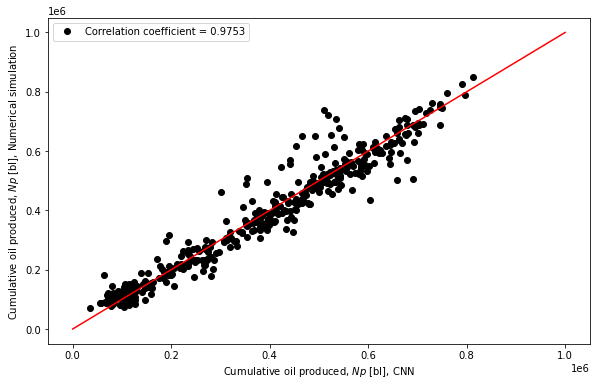

In [78]:
## For saturation 
xline=[0,1000000]
yline=[0,1000000]
AvgTruth=np.zeros(y_test.shape[0])
AvgTest=np.zeros(y_test.shape[0])
plt.figure(figsize=(9.708,6));
plt.plot(Np_pred,Np,'ko',label='Correlation coefficient = 0.9753');
plt.plot(xline,yline,'-r');
plt.xlabel('Cumulative oil produced, $Np$ [bl], CNN');
plt.ylabel('Cumulative oil produced, $Np$ [bl], Numerical simulation');
plt.legend(loc='best');

plt.savefig("Npvalidation.png", bbox_inches="tight");
plt.show();

### Error in terms of volume testing

In [82]:
prod_MSE=np.zeros(y_test.shape[0])
for ix in range(y_test.shape[0]):
    mse=_percentage_error(np.sum(Np_t[ix,:,:]),np.sum(Np_p[ix,:,:]))
    prod_MSE[ix]=mse*(32**2)
    #print(score,err)
print(np.std(prod_MSE))

157.57394855915203


In [83]:
def invScaler(X,X_std):
    X_inv=X_std*(X.max() - X.min())+ X.min()
    return X_inv

#invScaler(X,X_std):
#preds_test.shape
#plot(preds_test[0,:,:,1])
preds_test_norm=invScaler(pressure[:,:,0,:,:],preds_test[:,:,:,1])
y_test_norm=invScaler(pressure[:,:,0,:,:],y_test[:,:,:,1])
#Pressure.shape

In [85]:
press_MSE=np.zeros(y_test.shape[0])
for ix in range(y_test.shape[0]):
    mse=_percentage_error(np.sum(y_test_norm[ix,:,:]),np.sum(preds_test_norm[ix,:,:]))
    press_MSE[ix]=mse*100
    #print(score,err)
print(np.std(press_MSE))



2.8903771341748086


In [89]:
y_test_norm.min()
y_test_norm.max()

4374.673

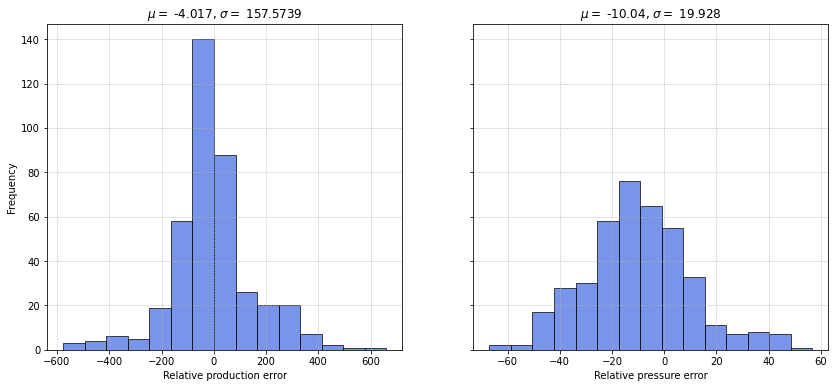

In [90]:
n_bins=15
fig, axs = plt.subplots(1, 2, figsize=(14,6),sharey=True)

N, bins, patches = axs[0].hist(prod_MSE, bins=n_bins,ec='black',fc='royalblue',alpha=0.7)
axs[0].set_title('$\mu = $ {0:.3f}, $\sigma = $ {1:.4f} '.format(np.mean(prod_MSE),np.std(prod_MSE)));
axs[0].set_xlabel('Relative production error');
axs[0].set_ylabel('Frequency');
axs[0].grid(True,linestyle='--',linewidth=0.5)

N, bins, patches = axs[1].hist(press_MSE*6.89476, bins=n_bins, ec='black',fc='royalblue',alpha=0.7)
axs[1].set_title('$\mu = $ {0:.2f}, $\sigma = $ {1:.3f} '.format(np.mean(press_MSE*6.89476),np.std(press_MSE*6.89476)));
axs[1].set_xlabel('Relative pressure error');
axs[1].grid(True,linestyle='--',linewidth=0.5)


plt.savefig('Histograms_Pressure_Prod.png',bbox_inches="tight")